In [174]:
from pathlib import Path
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem

from biosynfoni.moldrawing import draw, _get_highlight_loc_and_col

colourDict = {
    "taxonomy": {
        "Viridiplantae": "#B9C311",  # green
        "Bacteria": "#9BC2BA",  # teal
        "Fungi": "#CFC0D6",  # purple
        "Metazoa": "#FFAD61",  # light orange
        "Archaea": "#EB6737",  # soft red
        "Eukaryota": "#D2CEC4",  # pale grey
        "Cellular organisms": "#FFEAA0",  # yellow
        "Opisthokonta": "#FFC4CE",  # pink
    },
    "separation": {
        "1": "#081d58",  #'#57BAC0',  # navy,
        "2": "#225ea8",  #'#77BC4D',  # royal blue,
        "3": "#41b6c4",  #'#F3C55F',  # teal,
        "4": "#7fcdbb",  #'#F48861',  # turquoise,
        "5": "#c7e9b4",  #'#F7A8B8',  # lemon green,
        "6": "#edf8b1",  #'#F9CDAE',  # pale green,
        "7": "#FFEAA0",  # yellow
        "8": "#FF8B61",  # orange
        # "-1": "#c7e9b4",  #'#797979',  # lemon green,
        "-1": "#797979",  #'#797979',  # grey,
        "random pairs": "#c7e9b4",
        "control": "#c7e9b4",
    },
    "pathways": {
        "shikimate": "#A783B6",  # purple
        "acetate": "#FF8B61",  # orange,
        "mevalonate": "#B9C311",  # green,
        "methylerythritol": "#6FB5C6",  # blue
        "sugar": "#FFC4CE",  # pink
        "amino": "#FFEAA0",  # yellow
        "amino_acid": "#FFEAA0",  # yellow
    },
    "class": {
        # "Terpenoids": "#9BC2BA",  # soft bluegreen
        "Terpenoids": "#B9C311",  # green
        "Alkaloids": "#B4CAD8",  # purple
        "Shikimates and Phenylpropanoids": "#A783B6",  # purple
        "Fatty acids": "#FF8B61",  # orange
        "Carbohydrates": "#FFC4CE",  # pink
        "Polyketides": "#C21100",  # soft red
        "Amino acids and Peptides": "#FFEAA0",  # yellow
        "No NP-Classifier prediction": "#797979",
        "None": "#595959",
        "Synthetic": "#393939",
        "Multiple": "#BBBBBB",
        # lowercase
        # "terpenoids": "#9BC2BA",  # soft bluegreen
        "terpenoids": "#B9C311",  # green
        "alkaloids": "#B4CAD8",  # purple
        "shikimates and phenylpropanoids": "#A783B6",  # purple
        "fatty acids": "#FF8B61",  # orange
        "carbohydrates": "#FFC4CE",  # pink
        "polyketides": "#C21100",  # soft red
        "amino acids and peptides": "#FFEAA0",  # yellow
        # chebi:
        "phenylpropanoid": "#A783B6",  # purple
        "fatty_acid": "#FF8B61",  # orange
        "polyketide": "#C21100",  # soft red
        "alkaloid": "#B4CAD8",  # purple
        # "isoprenoid": "#9BC2BA",  # soft bluegreen
        "isoprenoid": "#B9C311",  # green
        "carbohydrate": "#FFC4CE",  # pink
        "amino_acid": "#FFEAA0",  # yellow
        "synthetic": "#393939",  # grey
    },
    "NPClassifier prediction": {
        "Terpenoids": "#B9C311",  # green
        "Alkaloids": "#B4CAD8",  # purple
        "Shikimates and Phenylpropanoids": "#A783B6",  # purple
        "Fatty acids": "#FF8B61",  # orange
        "Carbohydrates": "#FFC4CE",  # pink
        "Polyketides": "#C21100",  # soft red
        "Amino acids and Peptides": "#FFEAA0",  # yellow
        "No NP-Classifier prediction": "#797979",
        "None": "#595959",
        "Synthetic": "#393939",
        "Multiple": "#BBBBBB",
    },
    "chebi class": {
        "phenylpropanoid": "#A783B6",  # purple
        "fatty_acid": "#FF8B61",  # orange
        "polyketide": "#C21100",  # soft red
        "alkaloid": "#B4CAD8",  # purple
        # "isoprenoid": "#9BC2BA",  # soft bluegreen
        "isoprenoid": "#B9C311",  # green
        "carbohydrate": "#FFC4CE",  # pink
        "amino_acid": "#FFEAA0",  # yellow
        "synthetic": "#393939",  # grey
    },
}

# set the biosynfoni style
plt.style.use("biostylefoni.mplstyle")


# Figure 1: fingerprint example, pathway similarity example, biosynthetic distance results

## biosynthetic distance

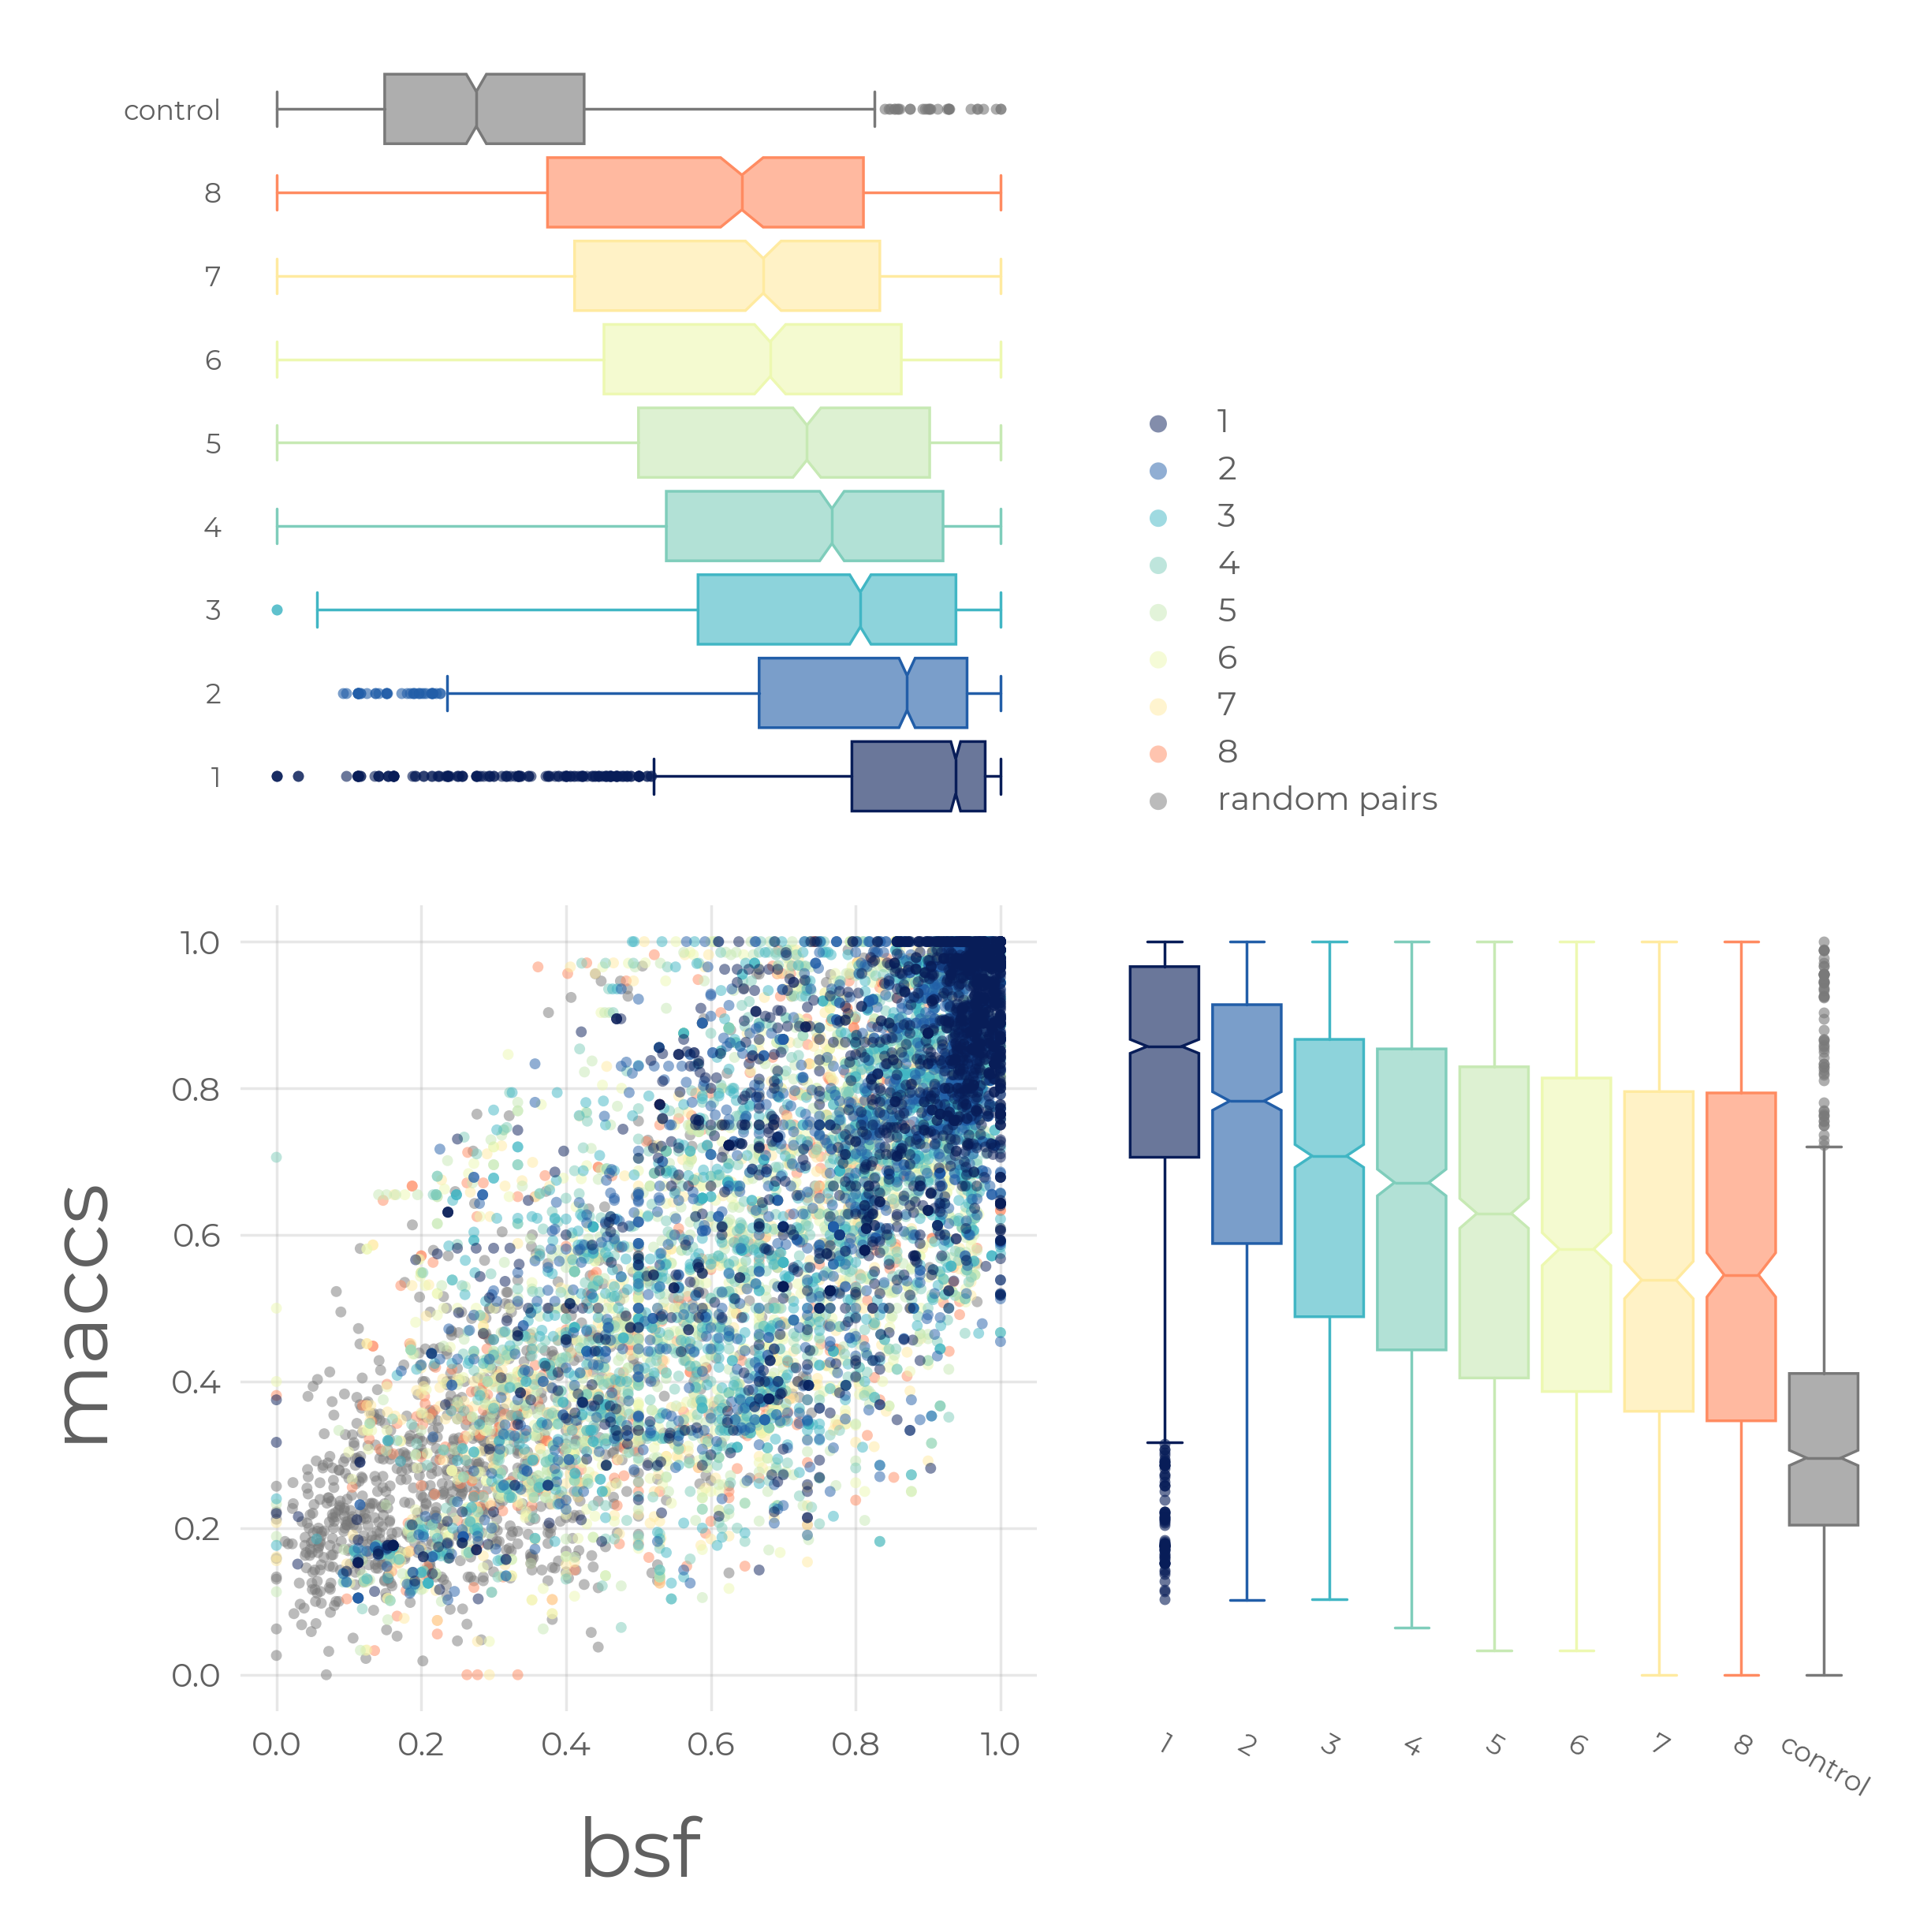

In [185]:
def cleanfmt(text):
    """
    Clean a string or list of strings to be used as labels in a plot

        Args:
            text (str or list): text to clean

        Returns:
            str or list: cleaned text

    Remarks:
        - replaces underscores with spaces
        - makes all text lowercase
    """
    if isinstance(text, str):
        return text.replace("_", " ").lower()
    elif isinstance(text, list):
        newtext = []
        for t in text:
            if isinstance(t, str):
                newtext.append(t.replace("_", " ").lower())
            else:
                newtext.append(t)
        return newtext
    else:
        return text


def _set_ax_boxplot_i_colour(
    ax_boxplot: mpl.container.BarContainer,
    i: int,
    colour: str,
    inner_alpha: float = 0.6,
):
    """
    Set the colour of a boxplot element

        Args:
            ax_boxplot (matplotlib.container.BarContainer): the boxplot to change
            i (int): the index of the element to change
            colour (str): the colour to change to
            inner_alpha (float): the alpha of the inner colour, optional. Default is 0.6

        Returns:
            matplotlib.container.BarContainer: the changed boxplot

    """
    translucent = mpl.colors.to_rgba(colour, inner_alpha)

    ax_boxplot["boxes"][i].set_facecolor(translucent)
    ax_boxplot["boxes"][i].set_edgecolor(colour)
    ax_boxplot["medians"][i].set_color(colour)
    ax_boxplot["whiskers"][i * 2].set_color(colour)
    ax_boxplot["whiskers"][i * 2 + 1].set_color(colour)
    ax_boxplot["caps"][i * 2].set_color(colour)
    ax_boxplot["caps"][i * 2 + 1].set_color(colour)
    ax_boxplot["fliers"][i].set_markeredgecolor(translucent)
    return ax_boxplot


def scatter_boxplots(
    df: pd.DataFrame,
    col_x: str,
    col_y: str,
    color_by: str = "stepnum",
    *args,
    **kwargs,
) -> plt.Figure:
    """
    Make a scatterplot with boxplots on the axes

        Args:
            df (pd.DataFrame): dataframe to plot
            col_x (str): column to plot on the x-axis
            col_y (str): column to plot on the y-axis
            figtitle (str): title of the figure
            color_by (str): column to colour by, optional. Default is "stepnum"
            *args: other arguments to pass to scatterplot
            **kwargs: other keyword arguments to pass to scatterplot
        Returns:
            plt.Figure: the figure

    """
    # make a square figure
    fig = plt.figure(figsize=(5, 5))
    # fig, ax = plt.subplots()
    # add gridspec for subplots

    gs = fig.add_gridspec(
        2,
        2,
        # width_ratios=(4, 1),
        # height_ratios=(1, 4),
        # left=0.1, right=0.9, bottom=0.1, top=0.9,
        wspace=-1,
        # hspace=-5,
    )

    sc_ax = fig.add_subplot(gs[1, 0])
    legax = fig.add_subplot(gs[0, 1])

    # Set aspect of the Axes manually to have points on 0 and 1 show better
    # ax.set_xlim(-0.05, 1.05)
    # ax.set_ylim(-0.05, 1.05)

    # Get Data
    all_data_x = [
        np.array(df[df[color_by] == category][col_x].to_numpy(dtype=float))
        for category in df[color_by].unique()
    ]
    all_data_x = [x[~np.isnan(x)] for x in all_data_x]
    all_data_y = [
        np.array(df[df[color_by] == category][col_y].tolist())
        for category in df[color_by].unique()
    ]
    all_data_y = [y[~np.isnan(y)] for y in all_data_y]


    top_bp_ax = fig.add_subplot(gs[0, 0], sharex=sc_ax)
    right_bp_ax = fig.add_subplot(gs[1, 1], sharey=sc_ax)


    top_bp_ax.tick_params(length=0, labelbottom=False, labelsize=5)
    right_bp_ax.tick_params(length=0, labelrotation=-30, labelleft=False, labelsize=5)
    legax.tick_params(length=0, labelleft=False, labelbottom=False, labelsize=0)
    sc_ax.tick_params(length=0)

    labels = [
        f"{category}" if category != "-1" else "control"
        for category in df[color_by].unique()
    ]
    # make boxplots where the boxes are 5px apart
    xplot = top_bp_ax.boxplot(all_data_x, vert=False, patch_artist=True, labels=labels, positions=[0.6*i for i in range(len(all_data_x))])
    yplot = right_bp_ax.boxplot(all_data_y, vert=True, patch_artist=True, labels=labels, positions=[0.6*i for i in range(len(all_data_y))])


    i = 0
    for category in df[color_by].unique()[::-1]:
        colour = colourDict[color_by][category]

        label = f"{category}" if category != "-1" else "random pairs"

        scatterplot = sc_ax.scatter(
            x=col_x,
            y=col_y,
            data=df[df[color_by] == category],
            c=colour,
            label=label,
            alpha=0.5,
            edgecolors="none",
            zorder=3,
            *args,
            **kwargs,
        )

    for category in df[color_by].unique():
        colour = colourDict[color_by][category]
        alpha = 0.6
        _set_ax_boxplot_i_colour(xplot, i, colour, inner_alpha=alpha)
        _set_ax_boxplot_i_colour(yplot, i, colour, inner_alpha=alpha)
        label = f"{category}" if category != "-1" else "random pairs"

        # scatter empty df, to get legend in right format in right position
        leg = legax.scatter(
            x=col_x,
            y=col_y,
            data=df[df[color_by] == category][0:0],
            c=colour,
            label=label,
            alpha=0.5,
            edgecolors="none",
            s=10,
        )
        leg.set_facecolor(mpl.colors.to_rgba(colour, alpha=alpha))

        i += 1

    # ==================================================

    legax.legend(loc="lower left", prop={"size": 6}, frameon=False)

    # # info for square drawing
    # squareside = 0.2
    # s_color = "#7A7979AA"
    # s_color = mpl.colors.to_rgba("#7A7979AA", alpha=0.3)
    # linewidth = 1

    # ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])
    sc_ax.set_xlabel(cleanfmt(col_x), labelpad=10)
    sc_ax.set_ylabel(cleanfmt(col_y), labelpad=10)
    # ax_xobs[0].set_title(figtitle, loc="center", pad=20)

    sc_ax.grid(True, alpha=0.3, linewidth=0.5, mouseover=True)
    gs.tight_layout(fig)

    return fig


df = pd.read_csv(
    f"{Path().home()}/article_bsf/output/biosynthetic_distances.tsv", sep="\t"
)  # , index_col=0)
df.separation = df.separation.astype(str).replace("control", "-1")

fig = scatter_boxplots(
    df,
    "bsf",
    "maccs",
    color_by="separation",
)

In [187]:
df[(df.bsf < 0.2) & (df.separation=="1")]

pathway_id                               mol1  \
70      P23-PWY                         ACETYL-COA   
75      P23-PWY                                SUC   
76      P23-PWY                            SUC-COA   
129    PWY-1187  3-METHYLTHIOPROPYLHYDROXAMIC-ACID   
198    PWY-4202                           ARSENATE   
199    PWY-4202                  RIBOSE-1-ARSENATE   
200    PWY-4202                          CPD0-2040   
201    PWY-4202                     METHYLARSONITE   
202    PWY-4202                          CPD-24323   
203    PWY-4202              DIMETHYLARSINOUS-ACID   
223    PWY-5140                          HEXANOATE   
306    PWY-5392                                SUC   
307    PWY-5392                            SUC-COA   
355    PWY-5690                    2-KETOGLUTARATE   
376    PWY-5789                            SUC-COA   
378    PWY-5789                 4-HYDROXY-BUTYRATE   
577    PWY-6322                          CPD-11735   
624    PWY-6627                          CPD-11020   
758    PWY-6969                    2-KETOGLUTARATE   
785    PWY-6995                          2-FUROATE   
788    PWY-6995                          CPD-14112   
791    PWY-6997                          2-FUROATE   
796    PWY-6997                          CPD-14112   
1005   PWY-7401                            CPD-577   
1240   PWY-7769                          CPD-11735   
1343   PWY-7948                          CPD-16942   
1755  PWY66-398                    2-KETOGLUTARATE   
1756  PWY66-398                            SUC-COA   
1836  REDCITCYC                    2-KETOGLUTARATE   
1837  REDCITCYC                            SUC-COA   
1846        TCA                    2-KETOGLUTARATE   
1847        TCA                            SUC-COA   

                                          mol2 separation       bsf       rdk  \
70                                    PYRUVATE          1  0.135593  0.023088   
75                                     SUC-COA          1  0.112903  0.030000   
76                             2-KETOGLUTARATE          1  0.161290  0.056497   
129   3-METHYLTHIOPROPYL-DESULFO-GLUCOSINOLATE          1  0.192308  0.116057   
198                          RIBOSE-1-ARSENATE          1  0.000000  0.030238   
199                                  CPD0-2040          1  0.000000  0.012959   
200                                  CPD-22658          1  0.000000  0.005803   
201                                  CPD-24323          1  0.030303  0.007505   
202                      DIMETHYLARSINOUS-ACID          1  0.029412  0.007505   
203                                  CPD-24324          1  0.111111  0.010267   
223                               HEXANOYL-COA          1  0.140625  0.030692   
306                                    SUC-COA          1  0.112903  0.030000   
307                            2-KETOGLUTARATE          1  0.161290  0.056497   
355                                    SUC-COA          1  0.161290  0.056497   
376                                 SUCC-S-ALD          1  0.096774  0.025714   
378                      4-HYDROXY-BUTYRYL-COA          1  0.112903  0.024408   
577                                  CPD-11737          1  0.115385  0.054974   
624                                  CPD-12679          1  0.187500  0.079832   
758                                    SUC-COA          1  0.161290  0.056497   
785                                     CPD-73          1  0.140625  0.085135   
788                            2-KETOGLUTARATE          1  0.153846  0.064201   
791                                     CPD-73          1  0.140625  0.085135   
796                            2-KETOGLUTARATE          1  0.153846  0.064201   
1005                                   CPD-575          1  0.191176  0.062676   
1240                                 CPD-11737          1  0.115385  0.054974   
1343                                 CPD-20681          1  0.153846  0.035436   
1755                               

In [14]:

# # scatter = scatter_boxplots(
# #             df,
# #             col_x="bsf",
# #             col_y="maccs",
# #             figtitle=f"Tanimoto for different reaction step numbers",
# #             color_by="separation",
# #         )

# palette = "mako"
# # df = df[df.separation != -1]
# # df.replace(-1, 100, inplace=True)
# # df = df[df.separation <= 4]


# sns.scatterplot(data=df, x="bsf", y="maccs", hue='separation', palette=palette, alpha=0.7, edgecolor='none',s=7)
# # add diagonal line
# plt.plot([0,1], [0,1], color='black', linestyle='--')
# # add the center of gravity per separation
# for i,sep in enumerate(df.separation.unique()):
#     color = sns.color_palette(palette, n_colors=len(df.separation.unique()))[i]
#     if sep == -1:
#         color = 'pink'
#     # add center of gravity and std in y and x direction
#     plt.plot(df[df.separation == sep].bsf.mean(), df[df.separation == sep].maccs.mean(), '*', color=color, markersize=15, label=f'sep {sep}')
#     # add std to both sides
#     plt.plot([df[df.separation == sep].bsf.mean()-df[df.separation == sep].bsf.std(), df[df.separation == sep].bsf.mean()+df[df.separation == sep].bsf.std()],
#              [df[df.separation == sep].maccs.mean(), df[df.separation == sep].maccs.mean()], color=color, linestyle='-', linewidth=1)
#     plt.plot([df[df.separation == sep].bsf.mean(), df[df.separation == sep].bsf.mean()],
#                 [df[df.separation == sep].maccs.mean()-df[df.separation == sep].maccs.std(), df[df.separation == sep].maccs.mean()+df[df.separation == sep].maccs.std()], color=color, linestyle='-', linewidth=1)

# print(df.shape)

## pathway visualisation


## pathway reconstruction

In [16]:
df = pd.read_csv(f"{Path().home()}/article_bsf/output/reconstructed_pathways.tsv",sep="\t", header=0,index_col=0)
# read in lists as lists
import ast
for col in df.columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)
# find where bsf_independent is same as true but maccs_independent is different

df["true_r"] = df["true"].apply(lambda x: x[::-1])

for key, val in {"bsf":"biosynfoni", "maccs": "maccs", "rdk":"rdkit", "morgan":"morgan"}.items():
    print(val, "independent: ", df[(df[f"{key}_independent"] == df.true )| (df[f"{key}_independent"] == df.true_r)].index.tolist())
    print(val,"with hint: ", df[(df[f"{key}_f_start"] == df.true) | (df[f"{key}_f_end"] == df.true)].index.tolist())

biosynfoni independent:  ['PWY-7135']
biosynfoni with hint:  ['PWY-6915', 'PWY-7135', 'PWY-7483', 'PWY-7711', 'PWY-7736', 'PWY-8133', 'PWY2DNV-5']
maccs independent:  []
maccs with hint:  ['GAMMAHEXCHLORDEG-PWY', 'PWY-7135', 'PWY-7812']
rdkit independent:  ['PWY-7572', 'PWY-7812']
rdkit with hint:  ['PWY-6475', 'PWY-7507', 'PWY-7572', 'PWY-7812']
morgan independent:  []
morgan with hint:  ['GAMMAHEXCHLORDEG-PWY', 'PWY-6475', 'PWY-7300', 'PWY-7483', 'PWY-7745']


In [17]:
# df["true"] = df["true"].apply(ast.literal_eval)
len(df.loc['PWY-8133'].true)

13

In [18]:
# draw the pathway
from rdkit import Chem

id_to_mol = {mol.GetProp("compound_id"): mol for mol in Chem.SDMolSupplier(f'{Path().home()}/article_bsf/data/input/metacyc.sdf')}

('FARNESYL-PP', 'FARNESYL-PP', 'FARNESYL-PP')
('CPD-1763', 'CPD-13621', 'CPD-13616')
('CPD-13616', 'CPD-13617', 'CPD-13618')
('CPD-13617', 'CPD-13616', 'CPD-13632')
('CPD-13618', 'CPD-13618', 'CPD-13625')
('CPD-13620', 'CPD-1763', 'CPD-13620')
('CPD-13625', 'CPD-13625', 'CPD-1763')
('CPD-13621', 'CPD-13620', 'CPD-13621')
('CPD-13632', 'CPD-13632', 'CPD-13617')
('CPD-13622', 'CPD-13622', 'CPD-13622')
('CPD-13619', 'CPD-13619', 'CPD-13619')


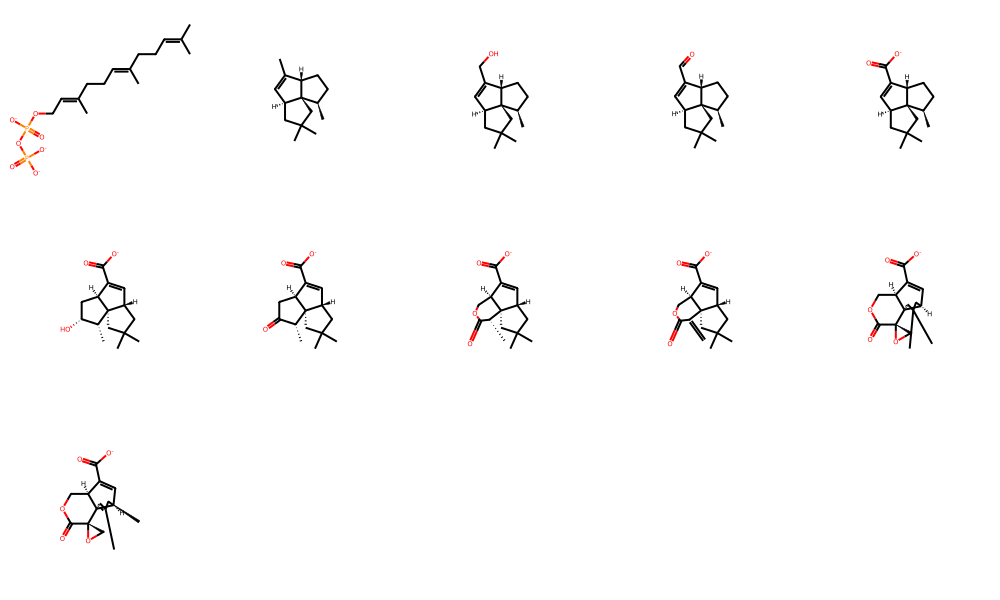

In [ ]:
pws = ['PWY-6915', 'PWY-7135', 'PWY-7483', 'PWY-7711', 'PWY-7736', 'PWY-8133', 'PWY2DNV-5']
compare = ['bsf_f_start', 'rdk_f_start']
# for pw in pws[1:]:
for pw in pws[0:]:
    mols = [id_to_mol[cpd] for cpd in df.loc[pw].true]
    # draw mols to grid
    print(*[id_ for id_ in zip(df.loc[pw].true, df.loc[pw][compare[0]], df.loc[pw][compare[1]])], sep='\n')
    break
Chem.Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=[mol.GetProp("_Name") for mol in mols])
# get similarities between the mols


## fingerprint example

In [ ]:
from biosynfoni import draw_with_highlights

mols = 
draw_with_highlights(mols,  legends=[mol.GetProp("_Name") for mol in mols])


NameError: name 'mols' is not defined

# Figure 2: Applicability domain - calculation times, coverage, substructure distribution

## calculation times

In [137]:


sdf_path = f"{Path().home()}/article_bsf/data/input/coconut.sdf"

def sizes(sdf_path) -> np.array:
    return np.array([mol.GetNumHeavyAtoms() for mol in Chem.SDMolSupplier(sdf_path)])

def times(fp_name) -> np.array:
    return np.loadtxt(f"{Path().home()}/article_bsf/coconut_{fp_name}_times.csv", delimiter=",", dtype=float)

def time_size_stats(times, sizes) -> np.array:
    """
    Function to get the data per fingerprint
    """
    assert len(times) == len(sizes), "The length of times and sizes should be the same"
    
    unique_sizes = np.unique(sizes)

    average_times = []
    for size in unique_sizes:
        average_times.append(np.mean(times[sizes == size]))

    std_times = []
    for size in unique_sizes:
        std_times.append(np.std(times[sizes == size]))

    return np.array([(size, avg_time, std_time) for size, avg_time, std_time in zip(unique_sizes, average_times, std_times)], 
                    dtype=[('size', int), ('average_time', float), ('std_time', float)])



In [138]:
sizes = sizes(sdf_path)

KeyboardInterrupt: 

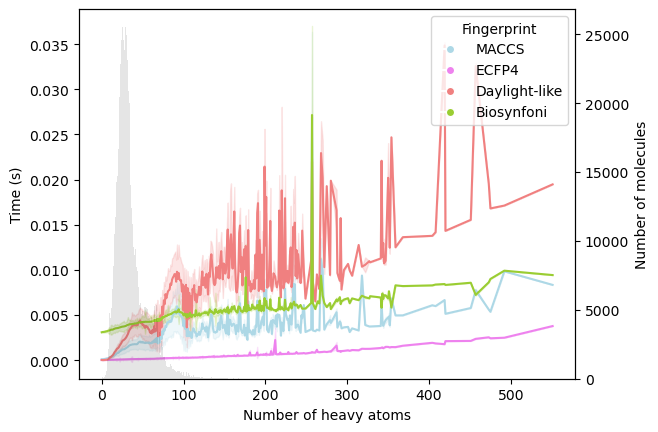

In [ ]:
# x axis coconut size, y axis time, line through averages per size, a 50% confidence interval around the line
fp_colour = {"maccs": "lightblue", "morgan": "violet", "rdk": "lightcoral", "bsf": "yellowgreen"}
for fp_name, colour in fp_colour.items():
    # plt.scatter(sizes, times(fp_name), s=1, color=colour, alpha=0.1)
    plt.xlabel("Number of heavy atoms")
    plt.ylabel("Time (s)")

    # plot the average time per size
    
    data = time_size_stats(times(fp_name), sizes)
    plt.plot(data["size"], data["average_time"], color=colour)

    # plot the 50% confidence interval around the average time per size
    plt.fill_between(
        data["size"],
        data["average_time"] - 0.5 * data["std_time"],
        data["average_time"] + 0.5 * data["std_time"],
        color=colour,
        alpha=0.2,
    )

# plot the sizes behind it with the y axis on the right
plt.twinx()
# as a histogram
plt.hist(sizes, bins=np.linspace(0, data["size"].max(), data["size"].max()), alpha=0.1, color="black")
plt.ylabel("Number of molecules")


# make handles for the legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colour, label=actual_names[fp_name]) for fp_name, colour in fp_colour.items()]
plt.legend(handles=handles, title="Fingerprint")

plt.show()

# density plot of am

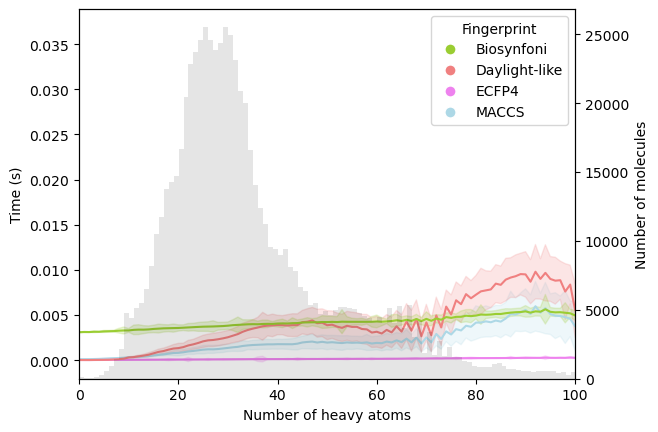

In [174]:
# x axis coconut size, y axis time, line through averages per size, a 50% confidence interval around the line
fp_colour = {"maccs": "lightblue", "morgan": "violet", "rdk": "lightcoral", "bsf": "yellowgreen"}
actual_names = {"maccs": "MACCS", "morgan": "ECFP4", "rdk": "Daylight-like", "bsf": "Biosynfoni"}
for fp_name, colour in fp_colour.items():
    # plt.scatter(sizes, times(fp_name), s=1, color=colour, alpha=0.1)
    plt.xlabel("Number of heavy atoms")
    plt.ylabel("Time (s)")

    # plot the average time per size
    
    data = time_size_stats(times(fp_name), sizes)

    plt.plot(data["size"], data["average_time"], color=colour)
    

    # plot the 50% confidence interval around the average time per size
    plt.fill_between(
        data["size"],
        data["average_time"] - 0.5 * data["std_time"],
        data["average_time"] + 0.5 * data["std_time"],
        color=colour,
        alpha=0.2,
    )

# plot the sizes behind it with the y axis on the right
plt.twinx()
# as a histogram
plt.hist(sizes, bins=np.linspace(0, data["size"].max(), data["size"].max()), alpha=0.1, color="black")
plt.ylabel("Number of molecules")


# make handles for the legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colour, markersize=8, label=actual_names[fp_name]) for fp_name, colour in fp_colour.items()]
handles.reverse()
plt.legend(handles=handles, title="Fingerprint")

# show x only until 100
plt.xlim(0, 100)

plt.show()

# density plot of am

In [166]:
print(np.average(times("maccs")))
print(np.average(times("morgan")))
print(np.average(times("rdk")))
print(np.average(times("bsf")))

0.0014902574219176983
9.979041091669671e-05
0.002816164522790954
0.003916785085435282


## coverage

In [148]:
from biosynfoni import Biosynfoni

sdf_path = f"{Path().home()}/article_bsf/data/input/coconut.sdf"
# mols = [mol for i, mol in enumerate(Chem.SDMolSupplier(sdf_path)) if i < 10]
mols = []
for i, mol in enumerate(Chem.SDMolSupplier(sdf_path)):
    if i < 10000:
        mols.append(mol)
    else:
        break

sizes = [mol.GetNumHeavyAtoms() for mol in mols]
coverages = [Biosynfoni(mol).get_coverage() for mol in mols]
# coverage against mol size in a hexbin plot


Text(0.5, 1.0, "Biosynfoni's coverage of natural products")

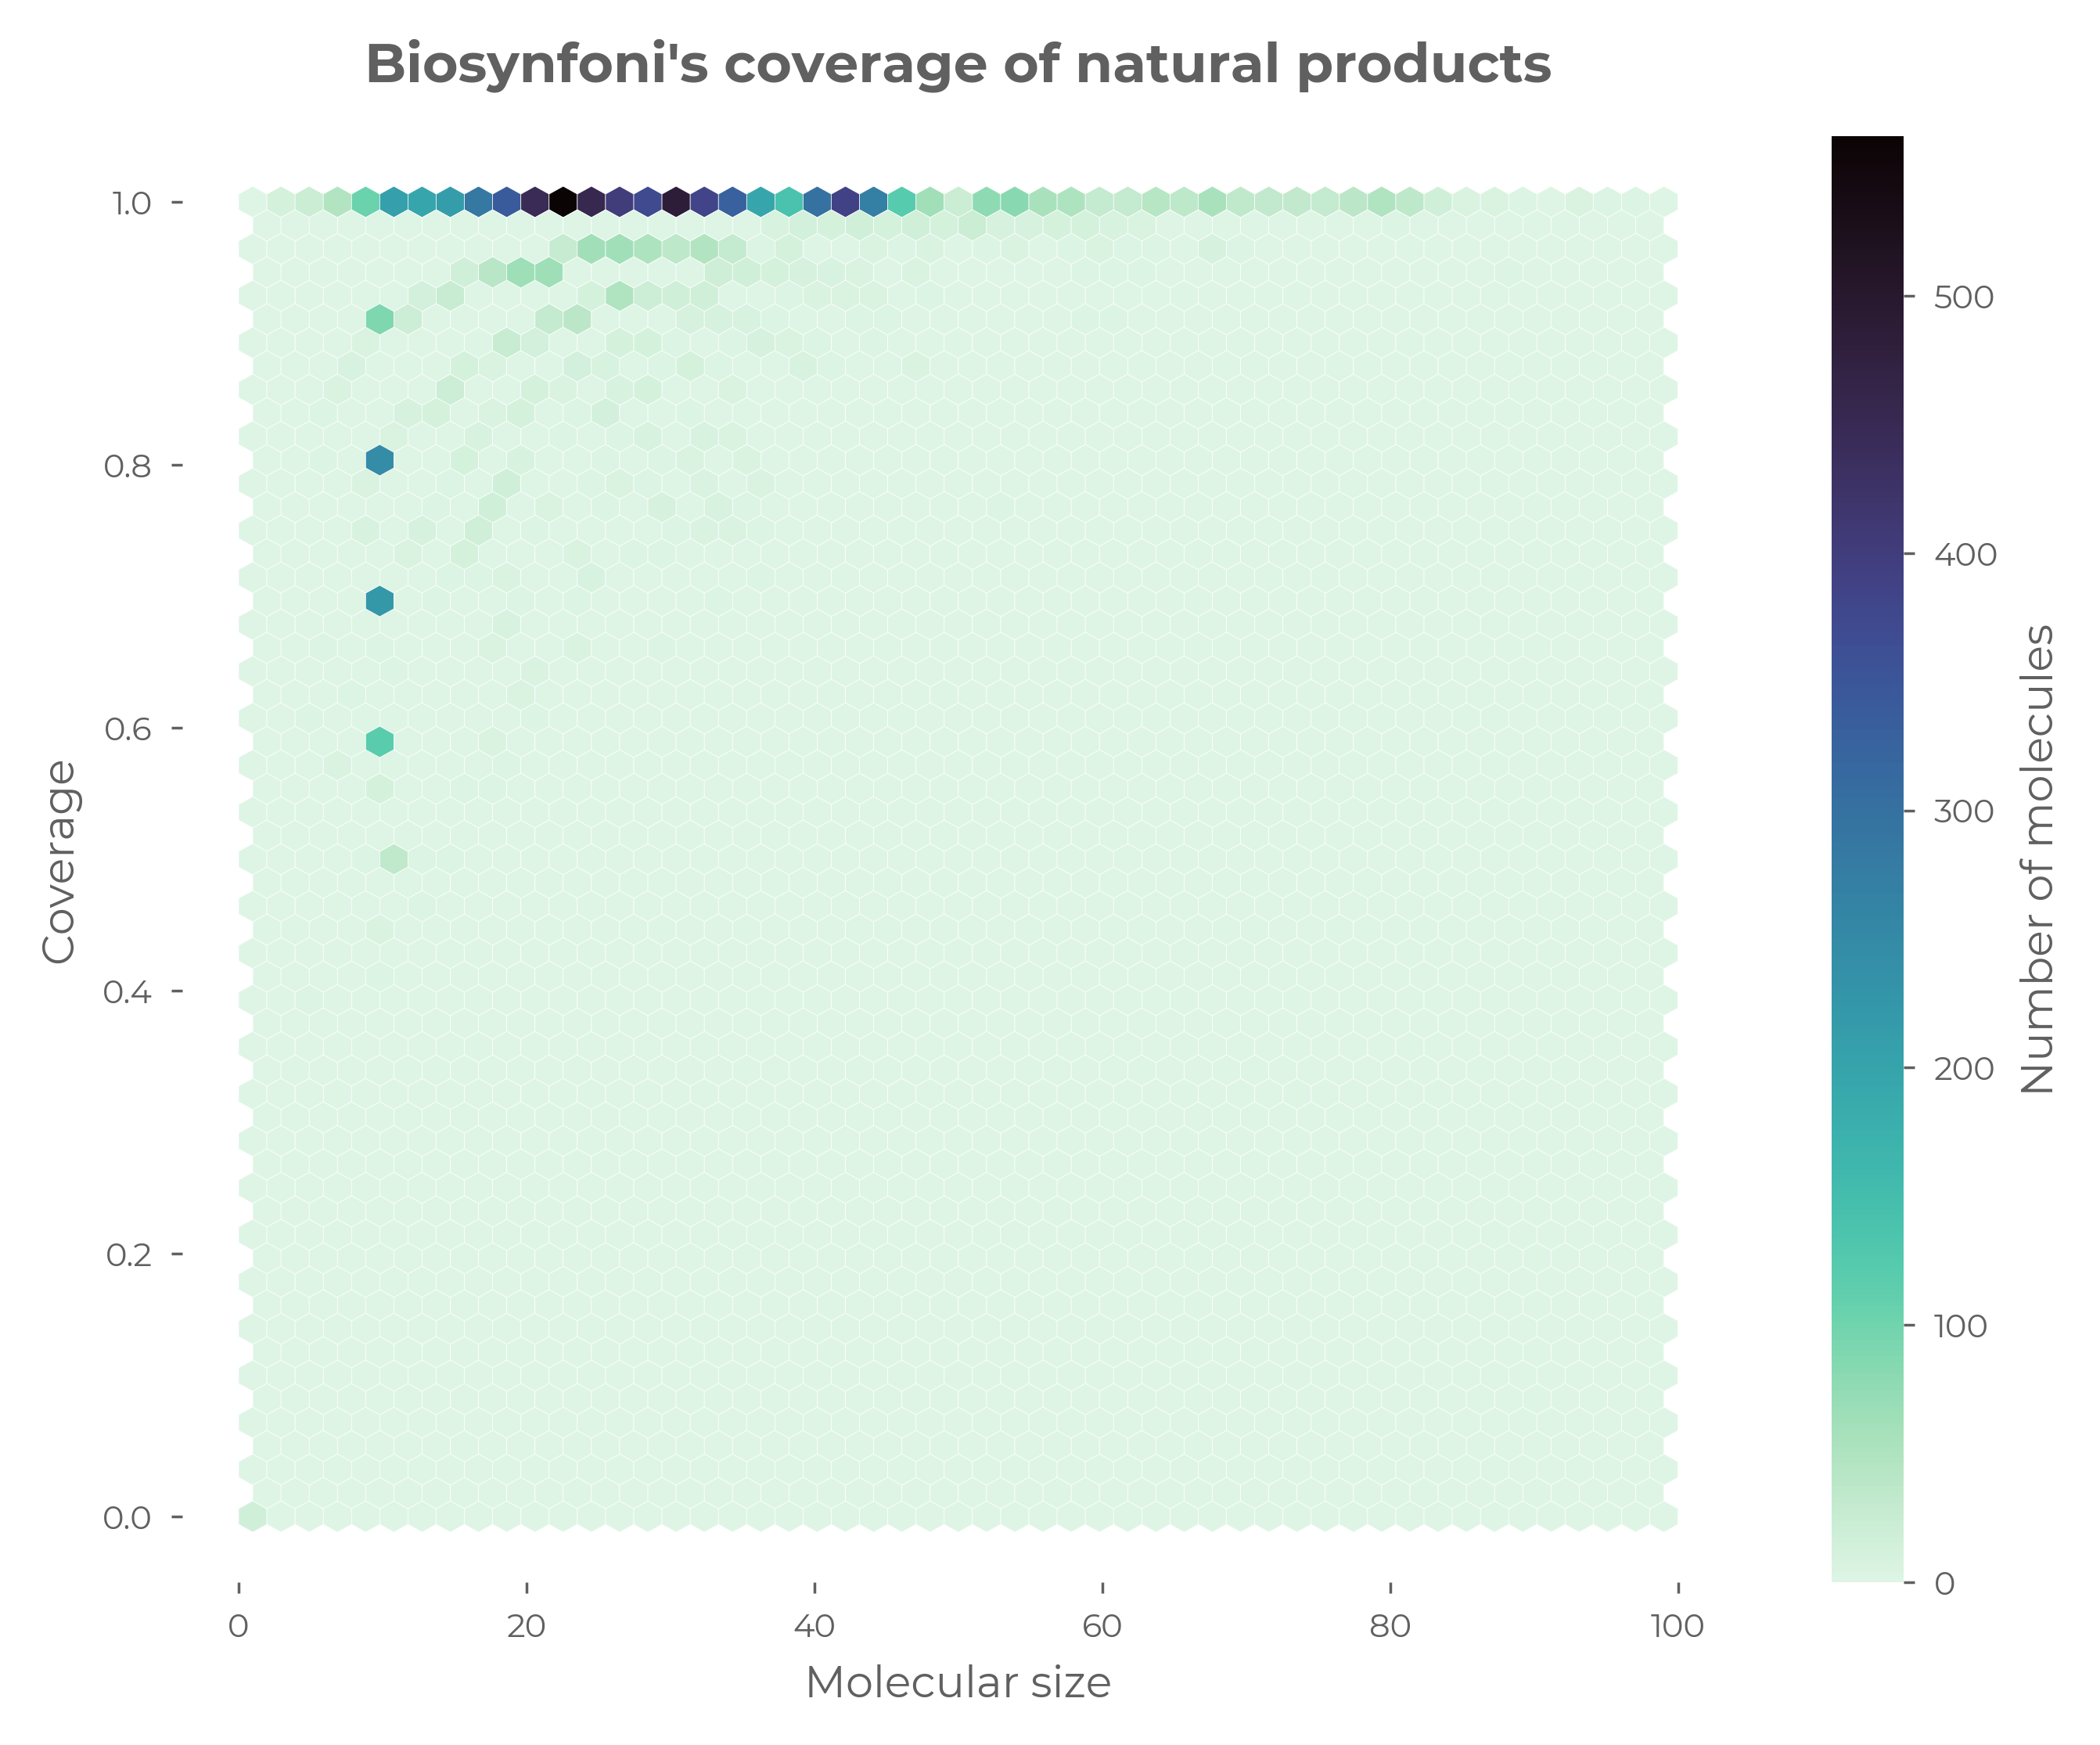

In [156]:

# get mako-r, but make the first 0.1 white and from there slowly go to the colours

cmap = sns.color_palette("mako_r", as_cmap=True)
# cmap = [cmap(i) for i in range(256)]
# cmap[0:5] = [(cmap[i][0],cmap[i][1],cmap[i][2], (i+1)/5) for i in range(1, 5)]
# cmap[0] = (1, 1, 1, 1)
# cmap = mpl.colors.ListedColormap(cmap)

df = pd.DataFrame.from_dict({"sizes": sizes, "coverages": coverages}, orient="index").T
df = df[df.sizes < 100]
plt.hexbin(df.sizes, df.coverages, gridsize=50, cmap=cmap, edgecolors='white', linewidths=0.1)
plt.colorbar(label="Number of molecules")
plt.xlabel("Molecular size")
plt.ylabel("Coverage")
plt.title("Biosynfoni's coverage of natural products")
# make sure all hexagons are hexagonal despite the limits

# plt.scatter(sizes, coverages, s=1, alpha=0.1)

0.9521612691495213 0.10913633610599108


/var/folders/qm/fzt72bc53hq6hhbj3wfljp5w0000gn/T/ipykernel_25728/950757116.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=coverages, inner="box", edgecolor="none", alpha=0.6, scale='width')


<Axes: >

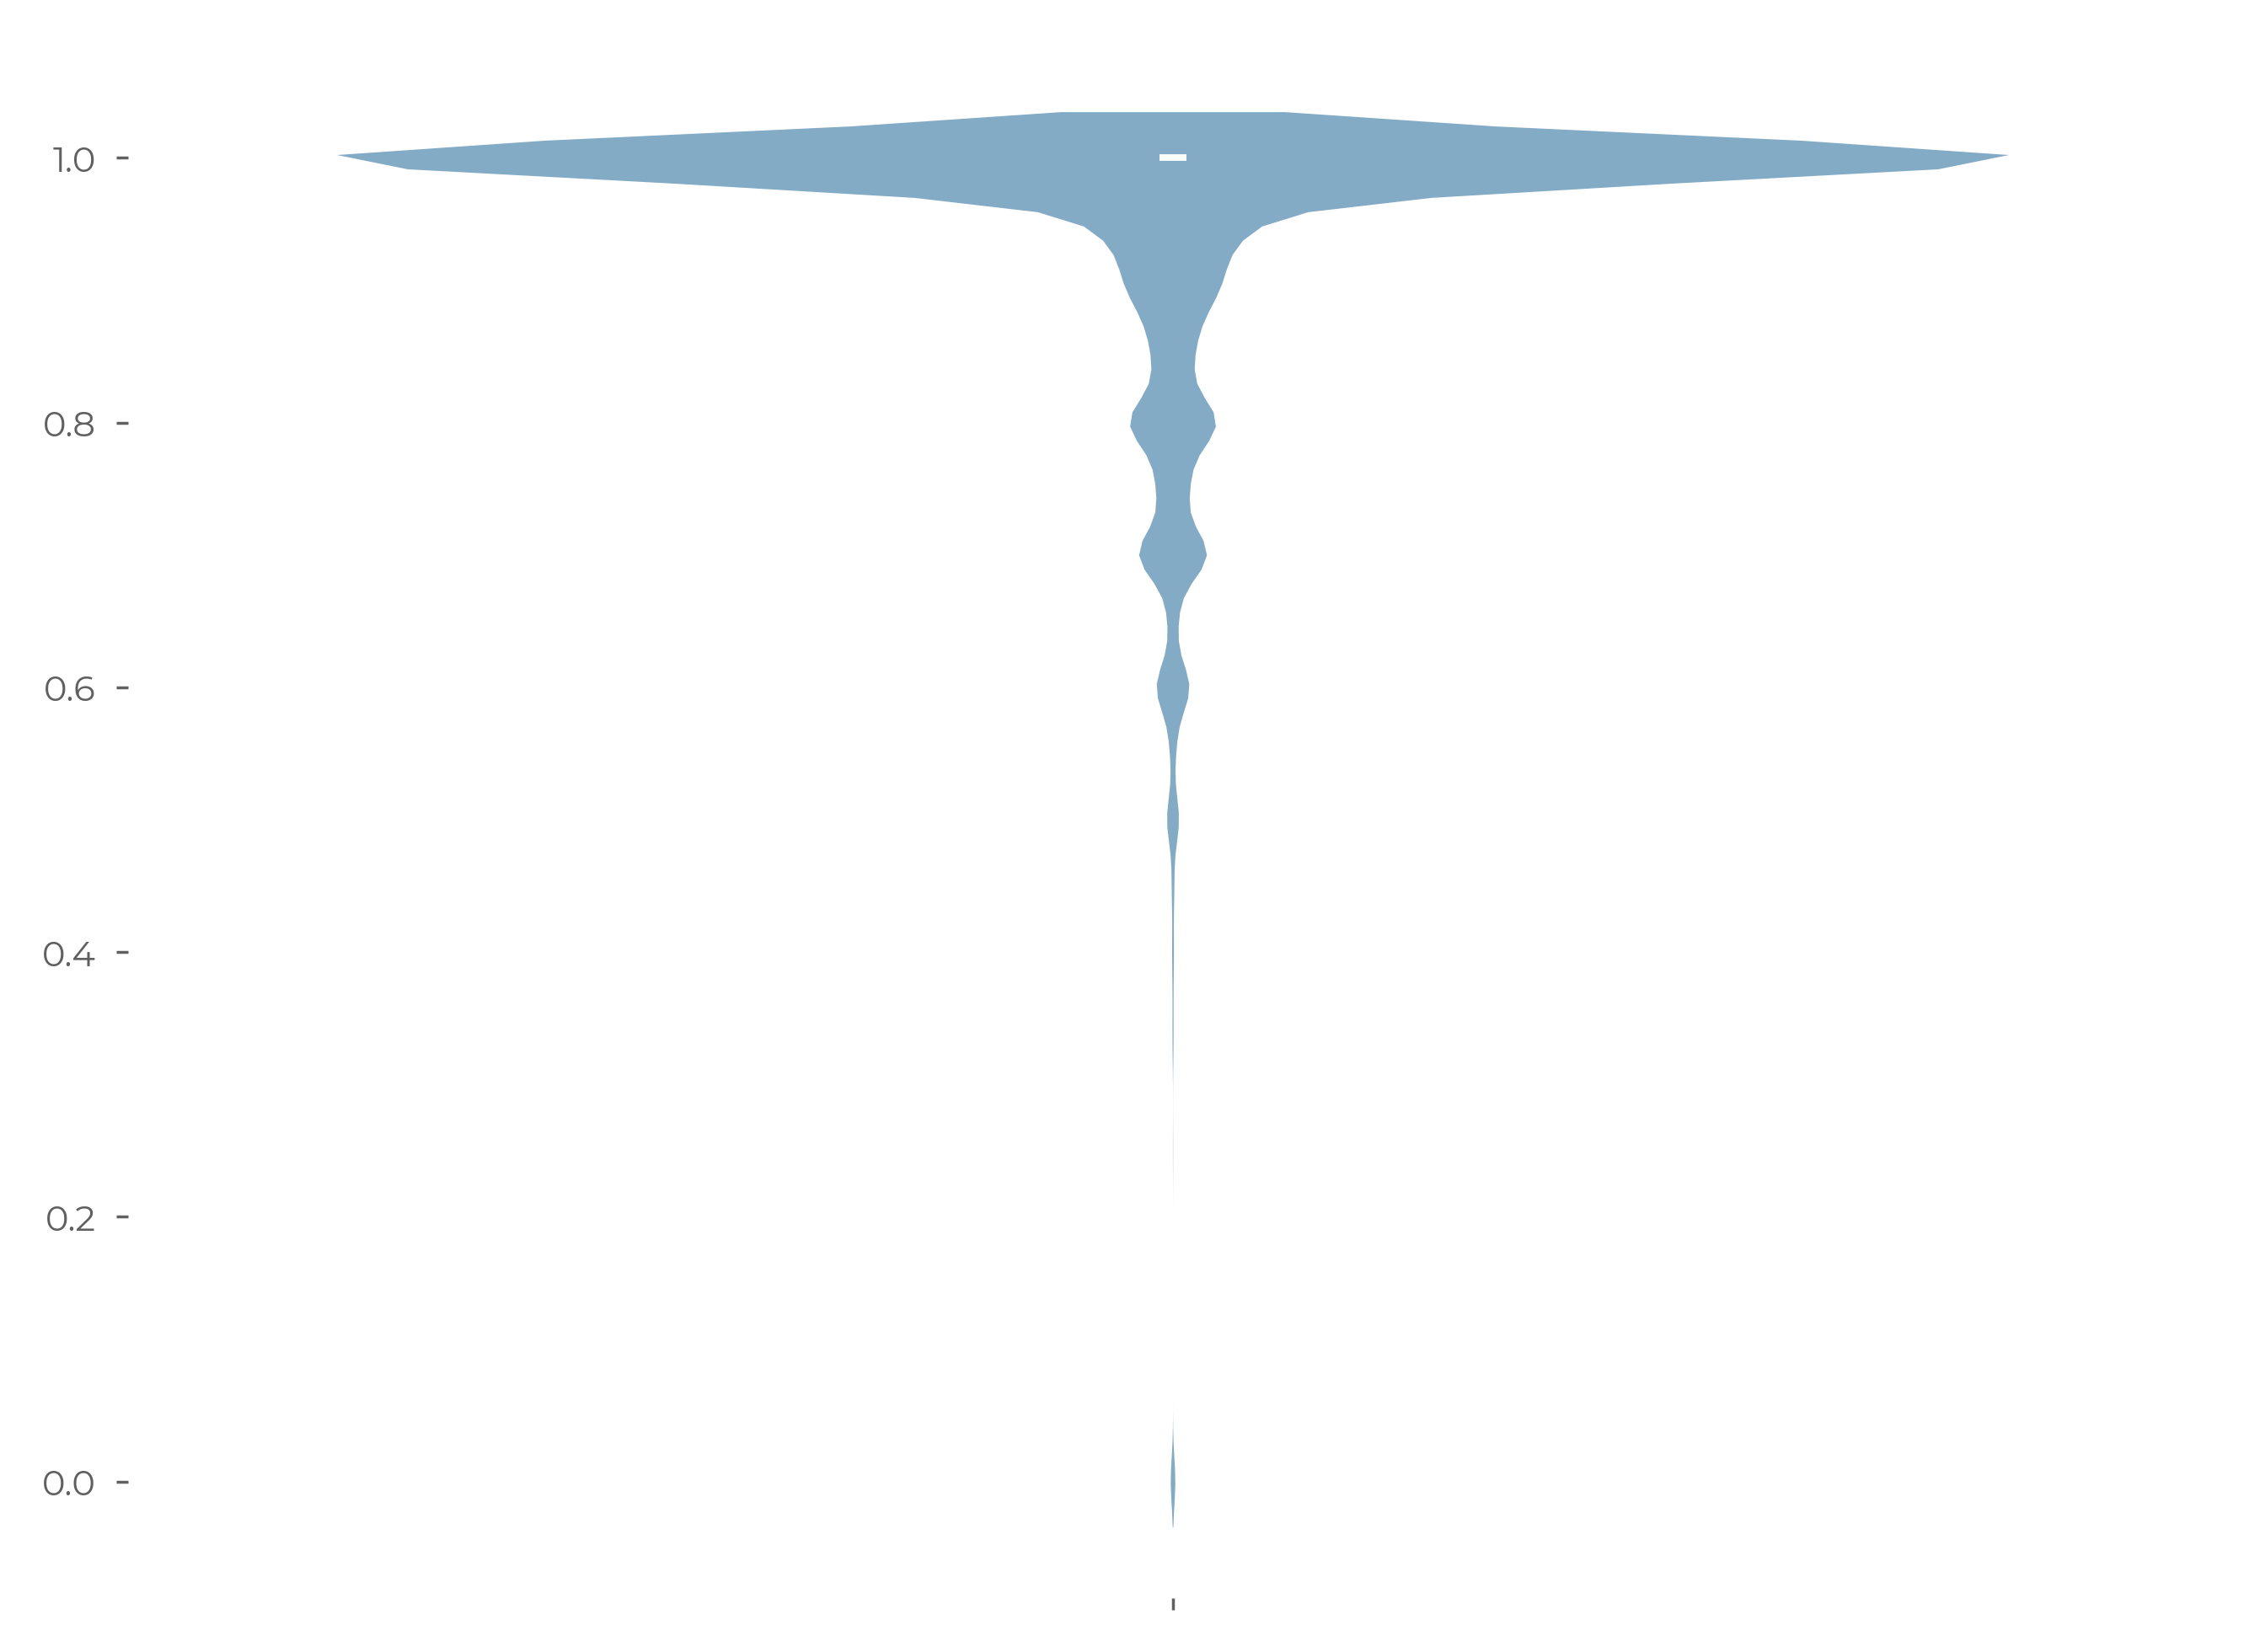

In [143]:
mean_coverage = np.mean(coverages)
std_coverage = np.std(coverages)

print(mean_coverage, std_coverage)
# print as violin plot with the mean and std as a line and the instances scatterd around it
sns.violinplot(data=coverages, inner="box", edgecolor="none", alpha=0.6, scale='width')
# sns.violinplot(data=coverages, inner="point", edgecolor="none", alpha=0.6)


<Axes: xlabel='size', ylabel='coverage'>

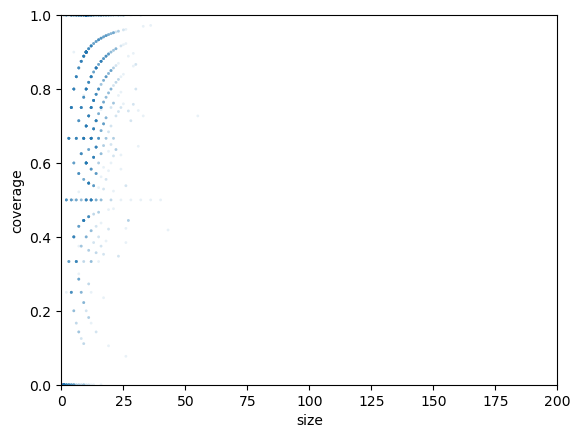

In [102]:
fig, ax = plt.subplots()
plt.xlim(0, 200)
plt.ylim(0, 1)
size_coverage = np.array([(s, c) for s, c in zip(sizes, coverages)], dtype=[('size', int), ('coverage', float)])

sns.scatterplot(data=pd.DataFrame(size_coverage), x="size", y="coverage",ax=ax, edgecolor='none', alpha=0.1, s=4)

## substructure occurrence

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 [Text(0, 0, 'coenzyme_a'),
  Text(1, 0, 'nadh'),
  Text(2, 0, 'nadph'),
  Text(3, 0, 'standard_amino_acids'),
  Text(4, 0, 'non-standard_amino_acids'),
  Text(5, 0, 'open_pyranose'),
  Text(6, 0, 'open_furanose'),
  Text(7, 0, 'pyranose'),
  Text(8, 0, 'furanose'),
  Text(9, 0, 'indoleC2N'),
  Text(10, 0, 'phenylC2N'),
  Text(11, 0, 'C5N'),
  Text(12, 0, 'C4N'),
  Text(13, 0, 'phenylC3'),
  Text(14, 0, 'phenylC2'),
  Text(15, 0, 'phenylC1'),
  Text(16, 0, 'isoprene'),
  Text(17, 0, 'acetyl'),
  Text(18, 0, 'methylmalonyl'),
  Text(19, 0, 'ethyl'),
  Text(20, 0, 'methyl'),
  Text(21, 0, 'phosphate'),
  Text(22, 0, 'sulfonate'),
  Text(23, 0, 'fluorine'),
  Text(24, 0, 'chlorine'),
  Text(25, 0, 'bromine'),
  Text(26, 0, 'iodine'),
  Text(27, 0, 'nitrate'),
  Text(2

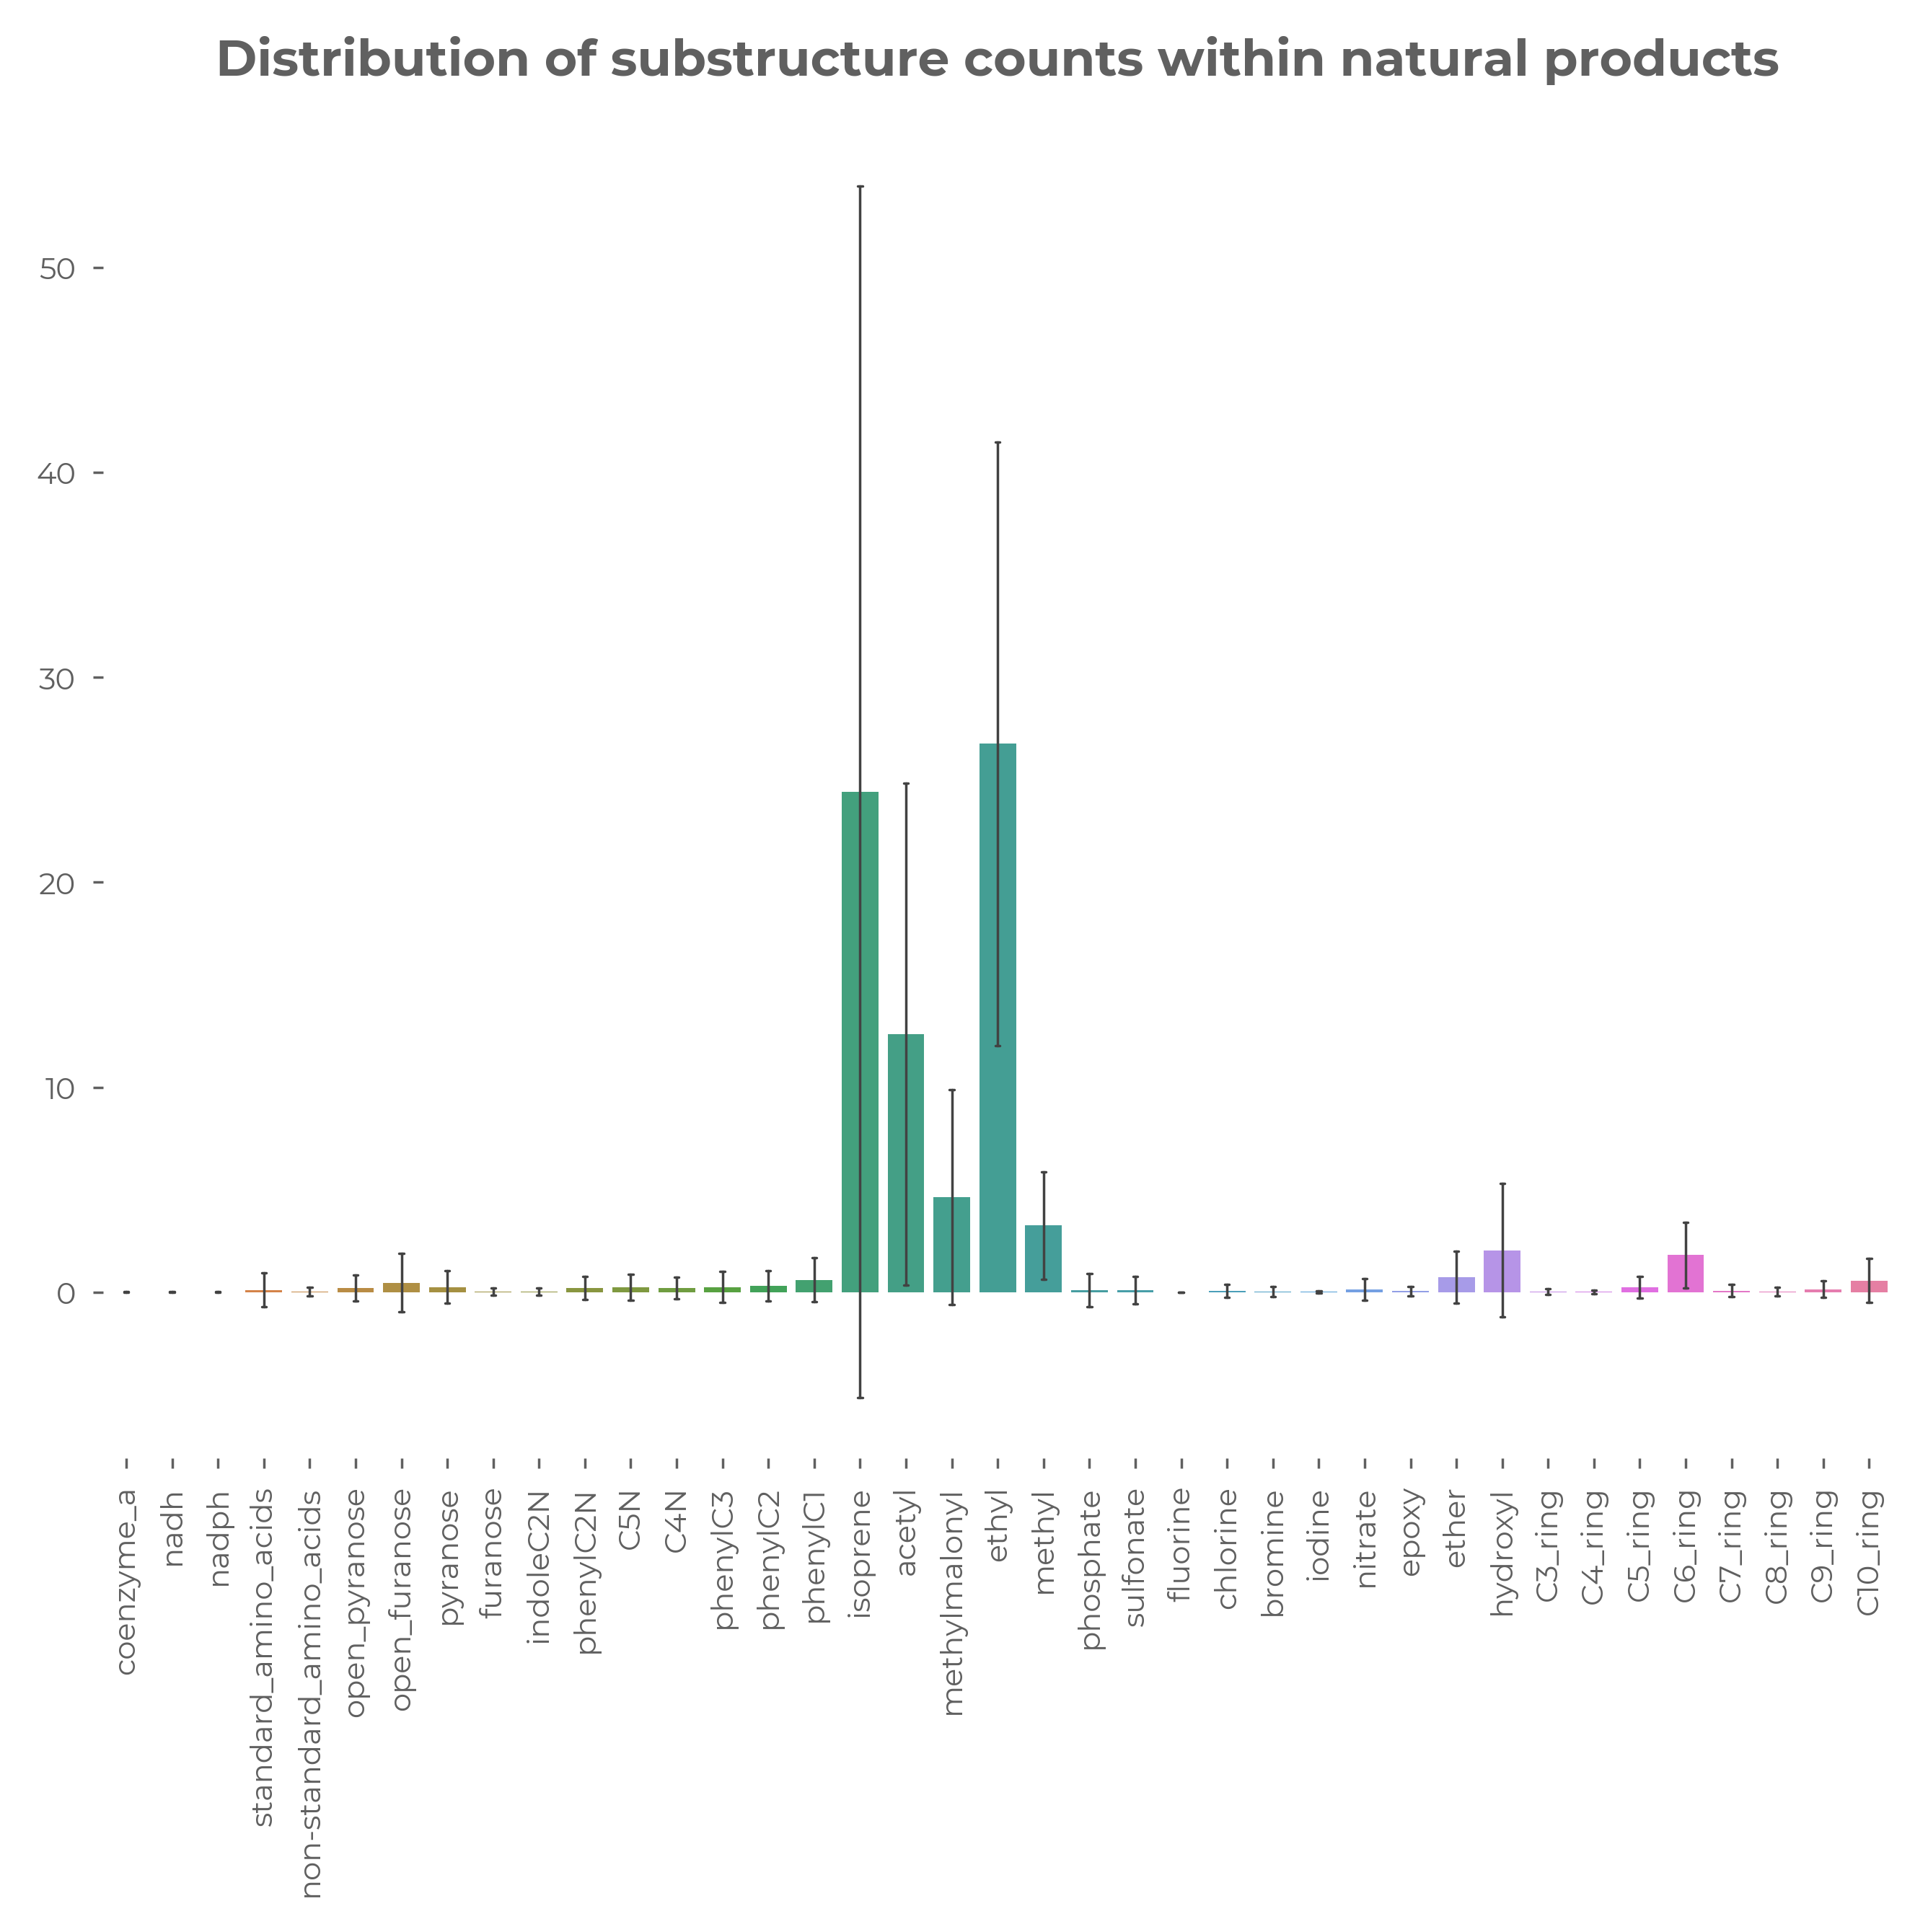

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from biosynfoni.subkeys import get_names, get_smarts

names = get_names()

df = pd.read_csv(f"{Path().home()}/article_bsf/fps/coconut_bsf.csv", names=names)

# make a violin plot of each of the columns
fig, ax = plt.subplots()
# sns.violinplot(data=df, ax=ax, inner="point", density_norm="width")
sns.barplot(data=df, ax=ax, errorbar='sd', capsize=0.1, err_kws={'linewidth': 0.5}, edgecolor="none", linewidth=0.5)
plt.title("Distribution of substructure counts within natural products")
plt.xticks(rotation=90)

# # instead of the xtick labels, place mol images
# from rdkit import Chem

# mols = [Chem.MolFromSmarts(smarts) for smarts in get_smarts()]
# from rdkit.Chem import Draw
# imgs = [Draw.MolToImage(mol, size=(1,1), ) for mol in mols]
# ax.set_xticklabels([f"{df.columns[i]}\n" for i in range(len(df.columns))], rotation=90)
# ax.set_xticklabels([])

# # add the images to the plot
# for i, img in enumerate(imgs):
#     ax.text(i, 0, f"{df.columns[i]}\n", ha='center', va='center', rotation=90, fontsize=6)
#     ax.imshow(img, extent=(i-0.5, i+0.5, 0, 1), aspect='auto')

## PMI map

100%|██████████| 695133/695133 [02:57<00:00, 3910.67it/s]


Text(0.5, 1.0, 'Pointwise Mutual Information of Biosynfoni Substructures')

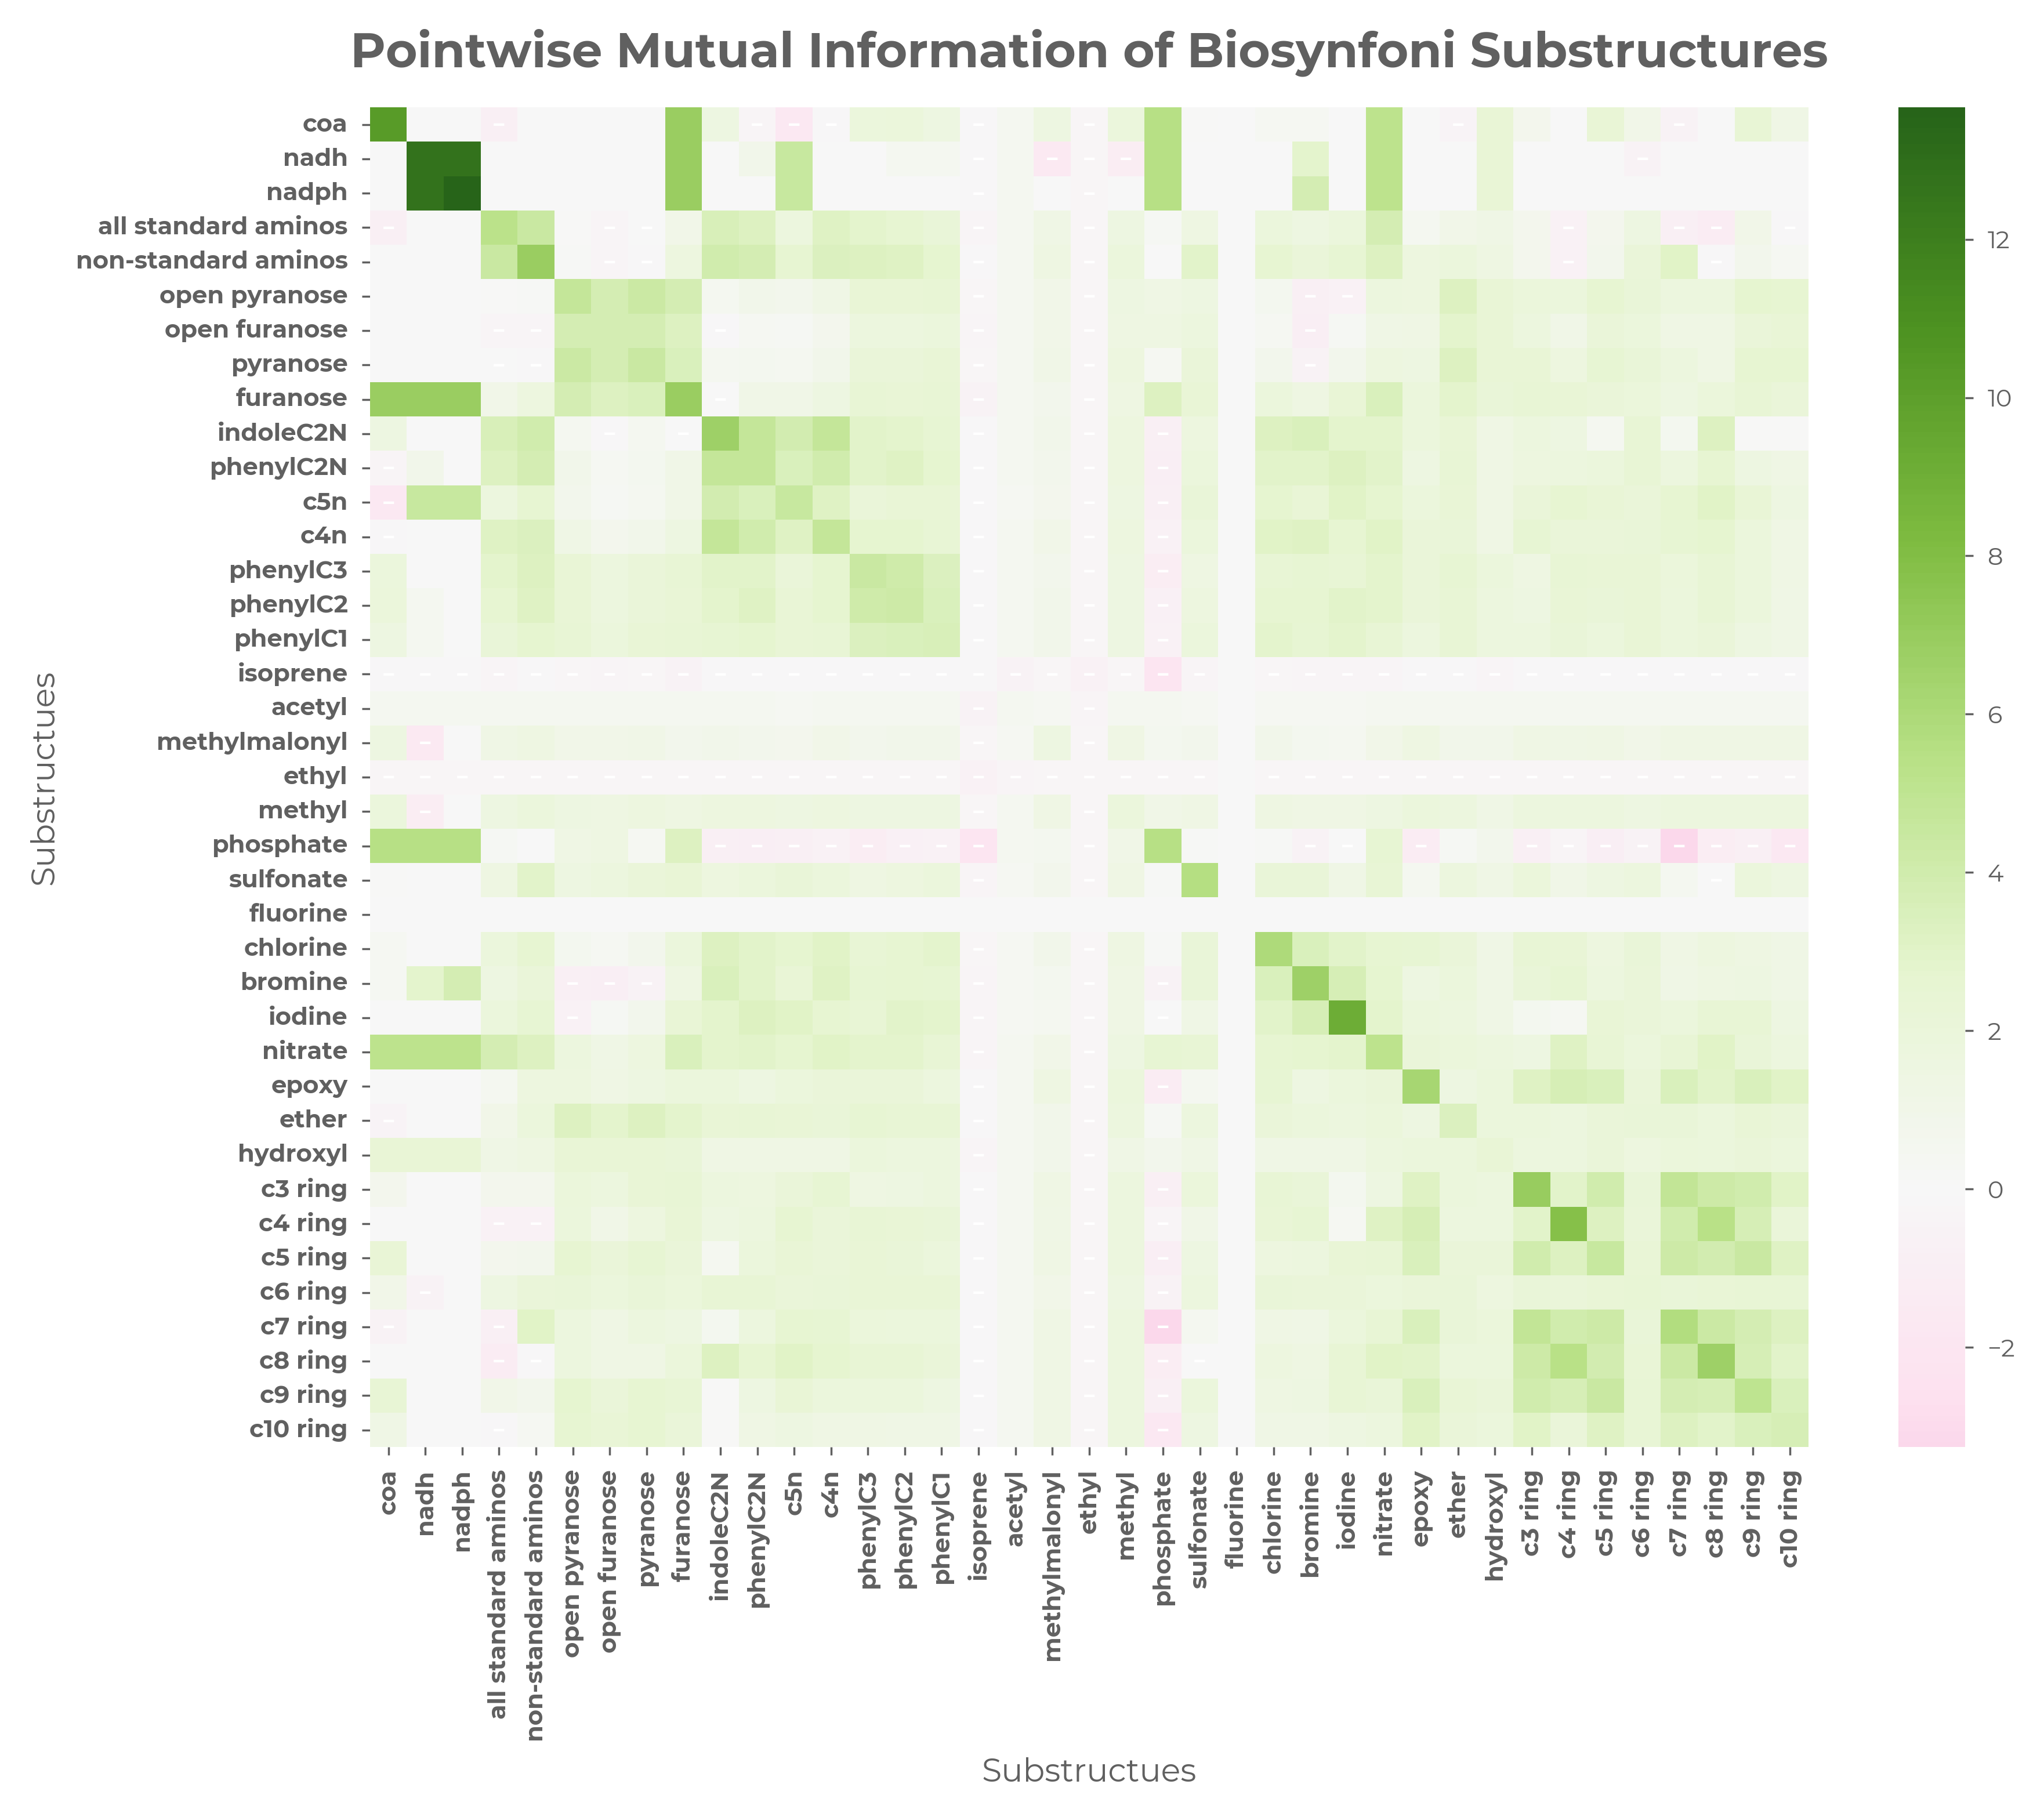

In [146]:
#!/usr/bin/env python3
import argparse, logging, os
import math
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from tqdm import tqdm

# from helper import  set_label_colors




def add_minuses(heatmap, array):
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            text = ""
            # if array[i, j] > 0:
            #     text = "+"
            if array[i, j] < 0:
                text = "-"
            heatmap.text(
                j + 0.5,
                i + 0.5,
                text,
                horizontalalignment="center",
                verticalalignment="center",
                color="white",
            )
    return None


def get_labels() -> list[str]:
    keys = [
        "coa",
        "nadh",
        "nadph",
        "all standard aminos",
        "non-standard aminos",
        "open pyranose",
        "open furanose",
        "pyranose",
        "furanose",
        "indoleC2N",
        "phenylC2N",
        "c5n",
        "c4n",
        "phenylC3",
        "phenylC2",
        "phenylC1",
        "isoprene",
        "acetyl",
        "methylmalonyl",
        "ethyl",
        "methyl",
        "phosphate",
        "sulfonate",
        "fluorine",
        "chlorine",
        "bromine",
        "iodine",
        "nitrate",
        "epoxy",
        "ether",
        "hydroxyl",
        "c3 ring",
        "c4 ring",
        "c5 ring",
        "c6 ring",
        "c7 ring",
        "c8 ring",
        "c9 ring",
        "c10 ring",
    ]
    return keys


def get_colours() -> list[str]:
    colours = [
        "grey",
        "grey",
        "grey",
        "#FFEAA0",
        "#FFEAA0",
        "#FFC4CE",  # pink
        "#FFC4CE",  # pink
        "#FFC4CE",  # pink
        "#FFC4CE",  # pink
        "#A783B6",
        "#A783B6",
        "#FF8B61",
        "#FF8B61",
        "#A783B6",
        "#A783B6",
        "#A783B6",
        "#B9C311",  # green
        "#FF8B61",
        "#FF8B61",
        "#FF8B61",
        "#FF8B61",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
        "grey",
    ]
    return colours


def _pearson_correlation_matrix(fps: np.array) -> np.array:
    # randomly subsample 10000

    # fps = fps[np.random.choice(fps.shape[0], 10000, replace=False), 3:]
    # fps = fps[:, 3:]
    mat = np.corrcoef(fps, rowvar=False, dtype=np.float16)
    # print(fps.shape)
    # print(mat.shape)
    return mat


def correlation_heatmap(fps: np.array) -> None:
    keys = get_labels()
    correlations = _pearson_correlation_matrix(fps)
    np.savetxt("correlations.tsv", correlations, delimiter="\t", fmt="%.2f")
    logging.warning(correlations.shape)
    hm = sns.heatmap(
        correlations,
        xticklabels=keys,
        yticklabels=keys,
        # cmap="coolwarm",
        cmap="PiYG",  # more colorblind-friendly diverging colormap
        vmin=np.min(fps),
        vmax=np.max(fps),
        center=0,  # center of the colormap
    )
    # hm.text(0.5, 0.5, "test", horizontalalignment="center", verticalalignment="center")
    # for all negative values, add a minus sign
    add_minuses(hm, fps)
    colours = get_colours()
    xt, yt = hm.get_xticklabels(), hm.get_yticklabels()
    # set_label_colors(hm.get_xticklabels(), colours)
    # set_label_colors(hm.get_yticklabels(), colours)
    return hm



fps = np.loadtxt(Path.home() / "article_bsf" / "fps" / "coconut_bsf.csv", delimiter=",")


# Count the number of times each bit is set.
cx = Counter()
cxy = Counter()

for idx in tqdm(range(fps.shape[0])):
    for bit_idx, bit in enumerate(fps[idx]):
        if bit > 0:
            cx[bit_idx] += bit

        for bit_idx2, bit2 in enumerate(fps[idx]):
            # if bit_idx == bit_idx2:
            #     continue
            if bit > 0 and bit2 > 0:
                # cxy[(bit_idx, bit_idx2)] += 1
                cxy[(bit_idx, bit_idx2)] += min(bit, bit2)

# Create lookup between key and fingerprint index.
x2i, i2x = {}, {}
keys = get_labels()
for i, x in enumerate(keys):
    x2i[x] = i
    i2x[i] = x

# Build sparse PMI matrix.
sx = sum(cx.values())
sxy = sum(cxy.values())
data, rows, cols = [], [], []
for (x, y), n in cxy.items():
    rows.append(x)
    cols.append(y)
    data.append(math.log((n / sxy) / (cx[x] / sx) / (cx[y] / sx)))

PMI = csc_matrix((data, (rows, cols)))
mat = PMI.toarray()

# Visualize matrix.
fig = plt.figure(figsize=(8, 6))
# sns.set(font_scale=0.5)
hm = sns.heatmap(
    mat,
    xticklabels=keys,
    yticklabels=keys,
    # cmap="coolwarm",
    cmap="PiYG",  # more colorblind-friendly diverging colormap
    vmin=np.min(mat),
    vmax=np.max(mat),
    center=0,  # center of the colormap
)
# hm.text(0.5, 0.5, "test", horizontalalignment="center", verticalalignment="center")
# for all negative values, add a minus sign
add_minuses(hm, mat)

# make ticklabels bold
hm.set_yticklabels(hm.get_yticklabels(), fontweight="bold")
hm.set_xticklabels(hm.get_xticklabels(), fontweight="bold")

# set_label_colors(hm.get_xticklabels(), colours)
# set_label_colors(hm.get_yticklabels(), colours)
colours = get_colours()
# set_label_colors(hm.get_xticklabels(), colours)
# set_label_colors(hm.get_yticklabels(), colours)

# plt.xticks(rotation=90)
# plt.yticks(rotation=0)

plt.ylabel("Substructues")
plt.xlabel("Substructues")
plt.title(
    f"Pointwise Mutual Information of Biosynfoni Substructures", size=12
)

# plt.savefig( bbox_inches="tight")
# plt.close()

# # get a correlation heatmap as well
# corr_hm = correlation_heatmap(fps)
# plt.title("Pearson correlation - non-overlap Biosynfoni on COCONUT", size=12)
# plt.savefig(args.o.replace(".png", "_correlation.png"), bbox_inches="tight")
# plt.close()

In [116]:

from itertools import chain
len(set(chain(*[match for match in Biosynfoni(Chem.SDMolSupplier(sdf_path)[0]).matches for match in match])))
# Chem.SDMolSupplier(sdf_path)[0].GetNumHeavyAtoms()

38

In [26]:
df = pd.read_csv(f"{Path().home()}/article_bsf/data/raw_data/coconut_complete-10-2024.csv")
df = df[~df.organisms.isna()]

# from rdkit.Chem import PandasTools
# coconut_ = PandasTools.LoadSDF(f"{Path().home()}/article_bsf/data/_old_raw_data/COCONUT_DB.sdf")
# print(len(coconut_))

# coconut_ = coconut_.query("textTaxa != '[notax]'").copy()
# print(len(coconut_))
# coconut_
# r"textTaxa.*\n\[[^n]"


/var/folders/qm/fzt72bc53hq6hhbj3wfljp5w0000gn/T/ipykernel_1191/3828439918.py:1: DtypeWarning:

Columns (38,40,42) have mixed types. Specify dtype option on import or set low_memory=False.



In [31]:

df[df.organisms.str.lower().str.contains("fungus")].shape

(933, 43)

In [35]:
df_ = pd.read_csv(f"{Path().home()}/article_bsf/data/input/coconut_taxonomy.csv", header=None, names=["compounds", "taxonomy"])
print(df_.shape) #695133
df_ = df_[~df_.taxonomy.isna()]
print(df_.shape) # 11286

(695133, 2)
(11286, 2)


In [18]:
df.columns

Index(['identifier', 'canonical_smiles', 'standard_inchi',
       'standard_inchi_key', 'name', 'iupac_name', 'total_atom_count',
       'heavy_atom_count', 'molecular_weight', 'exact_molecular_weight',
       'molecular_formula', 'alogp', 'topological_polar_surface_area',
       'rotatable_bond_count', 'hydrogen_bond_acceptors',
       'hydrogen_bond_donors', 'hydrogen_bond_acceptors_lipinski',
       'hydrogen_bond_donors_lipinski', 'lipinski_rule_of_five_violations',
       'aromatic_rings_count', 'qed_drug_likeliness', 'formal_charge',
       'fractioncsp3', 'number_of_minimal_rings', 'van_der_walls_volume',
       'contains_sugar', 'contains_ring_sugars', 'contains_linear_sugars',
       'murcko_framework', 'np_likeness', 'chemical_class',
       'chemical_sub_class', 'chemical_super_class',
       'direct_parent_classification', 'np_classifier_pathway',
       'np_classifier_superclass', 'np_classifier_class',
       'np_classifier_is_glycoside', 'organisms', 'collections', 'dois

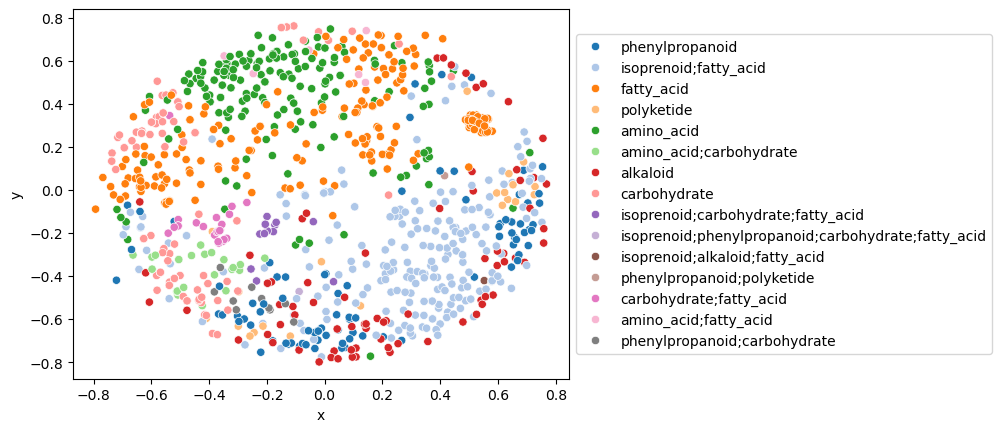

In [6]:
# show the projected data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(projected_X, columns=["x", "y"])
df["class"] = np.loadtxt(f"{Path().home()}/article_bsf/data/input/chebi_classes.csv", delimiter=",", dtype=str, usecols=1)[:1000]

sns.scatterplot(data=df, x="x", y="y", hue="class", palette="tab20")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [1]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
X = iris.data
X = pd.DataFrame(X,columns = iris.feature_names)
from tmap.tda import mapper, Filter
from tmap.tda.cover import Cover
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Step1. initiate a Mapper
tm = mapper.Mapper(verbose=1)
# Step2. Projection
lens = [Filter.MDS(components=[0, 1],random_state=100)]
projected_X = tm.filter(X, lens=lens)
clusterer = DBSCAN(eps=0.75, min_samples=1)
cover = Cover(projected_data=MinMaxScaler().fit_transform(projected_X), resolution=20, overlap=0.75)

/Applications/anaconda3/envs/bsf_ext/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Filtering by MDS.
...calculate Filter(which used to create cover) using the provided euclidean lens.


/Applications/anaconda3/envs/bsf_ext/lib/python3.12/site-packages/sklearn/manifold/_mds.py:629: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



Filtering has been completed.


# Figure 3: Applications - unsupervised clustering, supervised classification, biosynthetic pathway reconstruction

## dimensionality reduction

In [29]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# sim = np.loadtxt(Path.home() / "article_bsf" / "output" / "bsf_sim.csv", delimiter=",")

# sim = np.triu(sim) + np.triu(sim, 1).T
# np.fill_diagonal(sim, 1)

# # sns.heatmap(sim, cmap="coolwarm", center=0,vmax=1, square=True)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"{Path.home()}/article_bsf/output/maccs_umap.csv", header=None)
df.columns = ["x", "y"]
df["class"] = np.loadtxt(f"{Path.home()}/article_bsf/data/input/chebi_classes.csv", delimiter=",", dtype=str, usecols=1)[:1000]

sns.scatterplot(data=df, x="x", y="y", hue="class", palette="tab20")

ValueError: Length of values (1000) does not match length of index (18926)

Failed to patch pandas - unable to change molecule rendering


(13209, 92)


<Axes: xlabel='x', ylabel='y'>

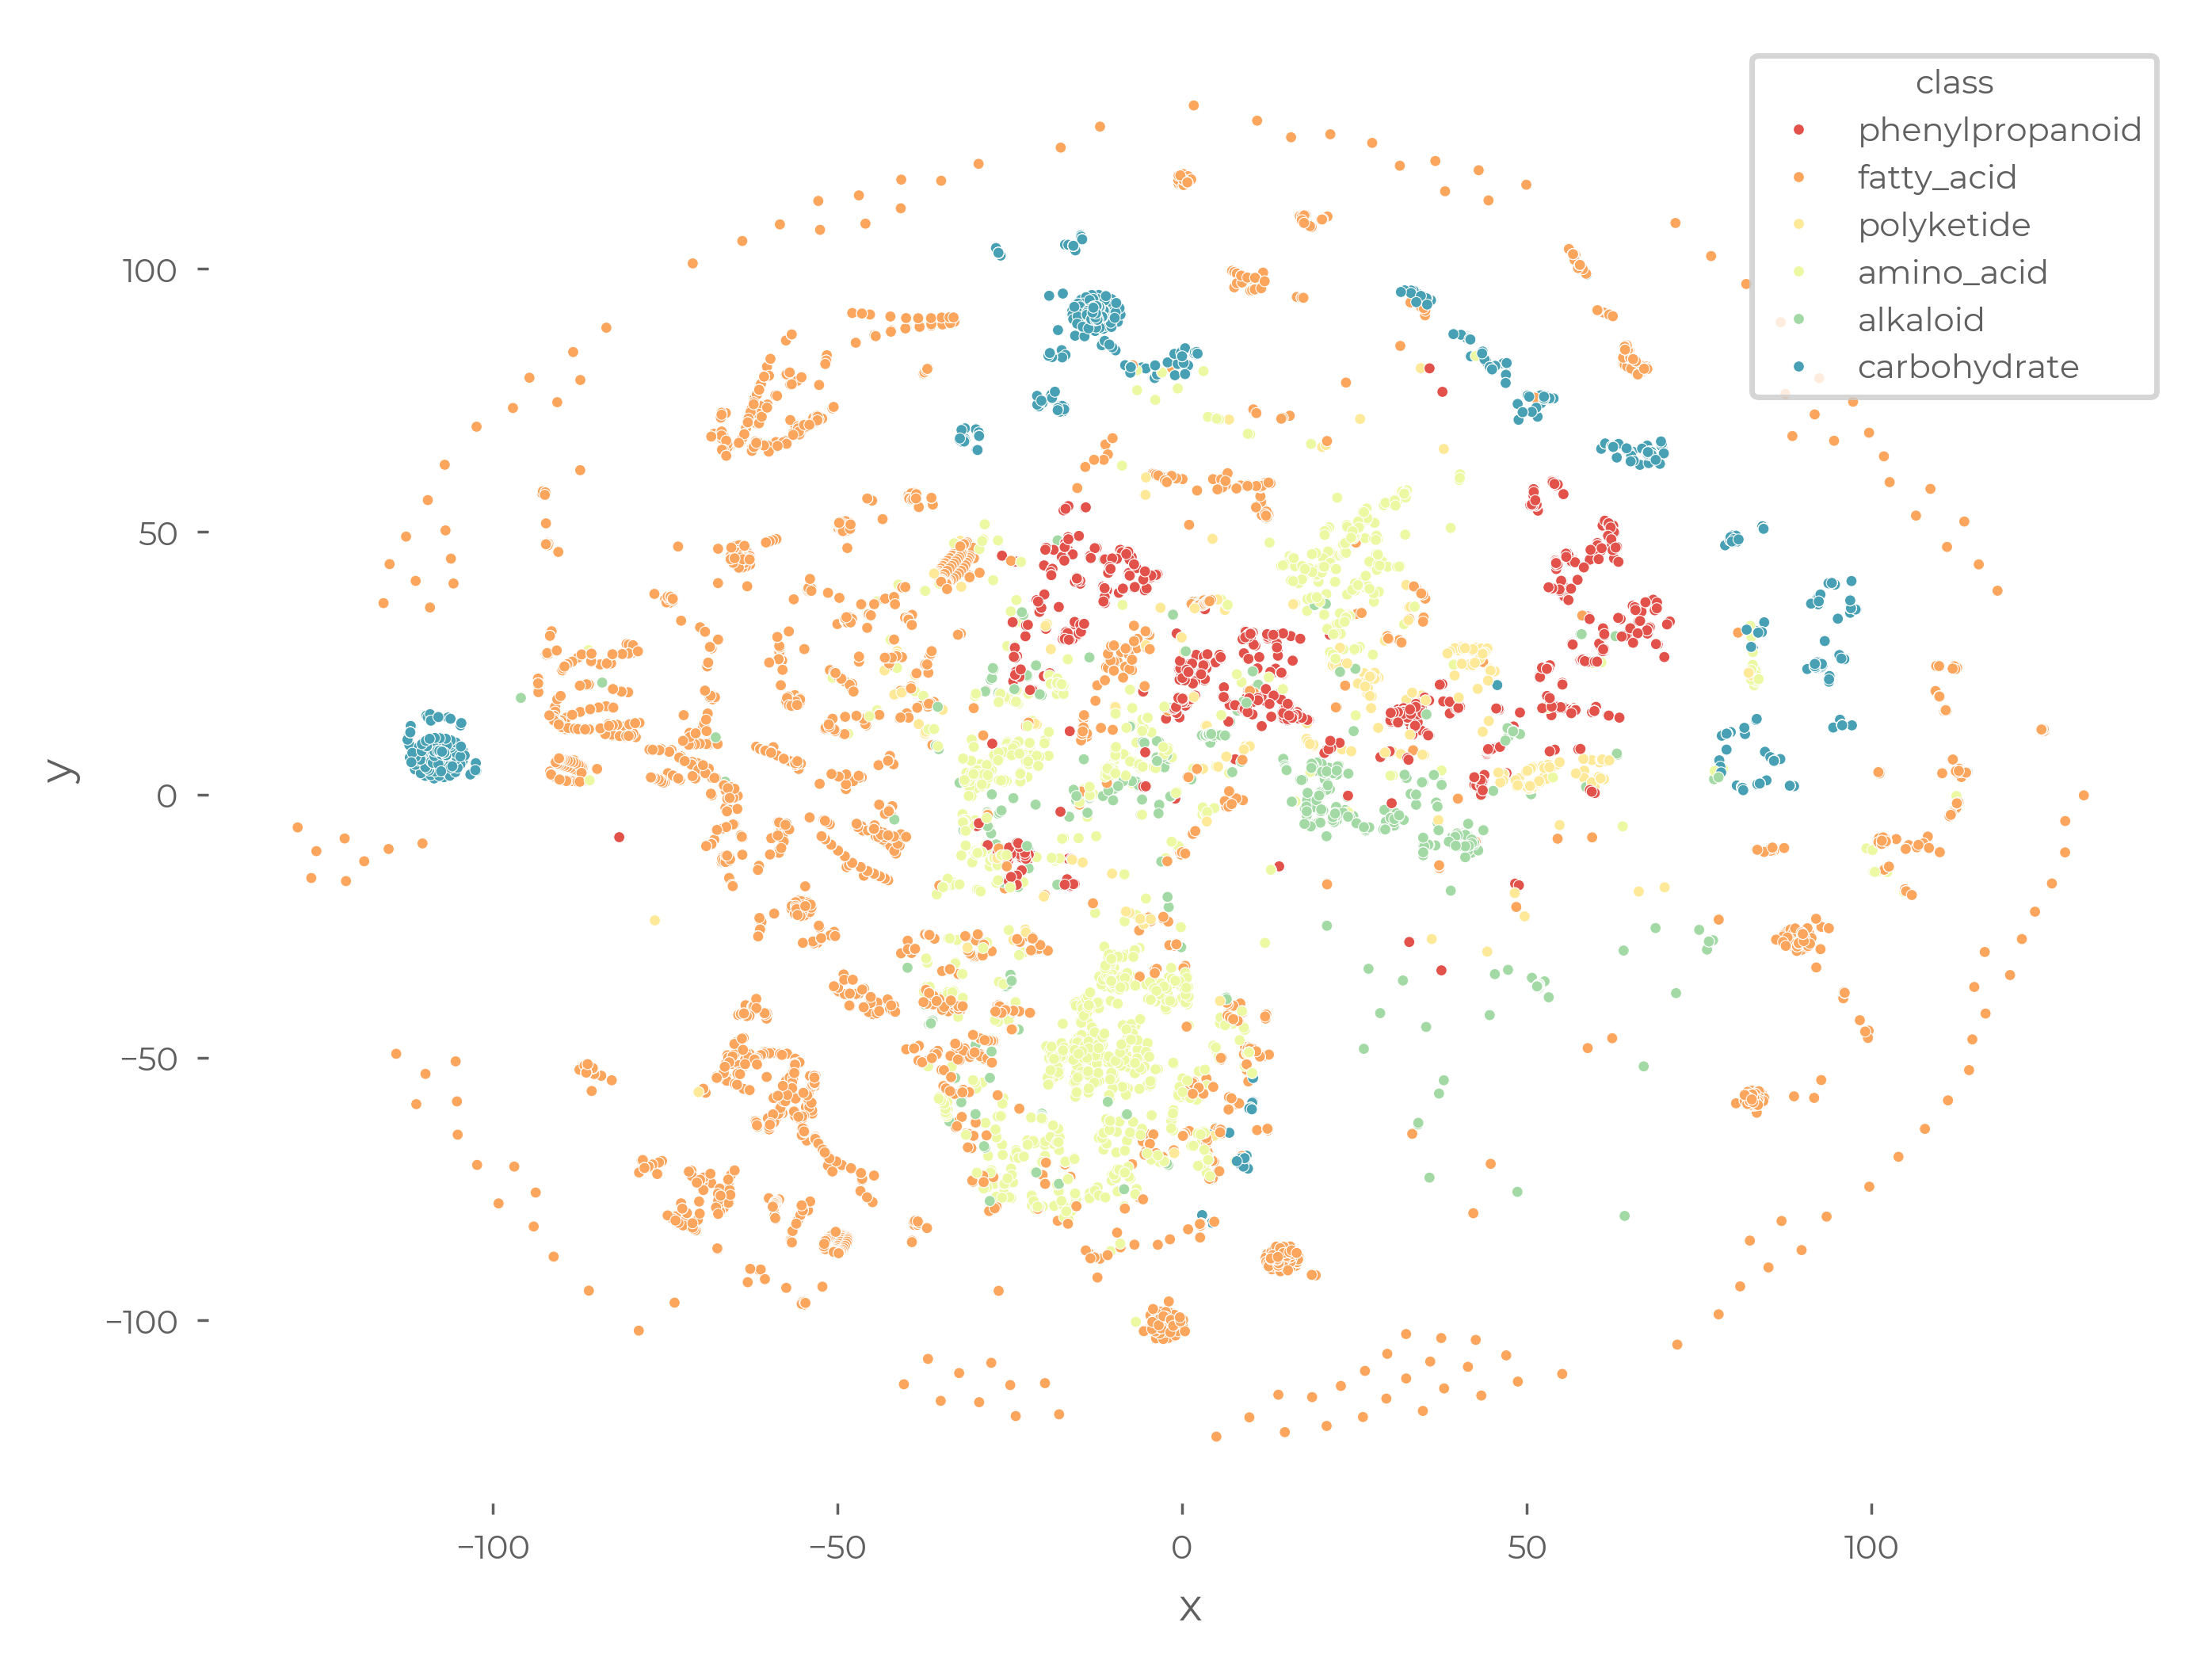

In [159]:
from pathlib import Path

import pandas as pd
import numpy as np
#import PandasTools
from rdkit import Chem 
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools




df = pd.read_csv(f"{Path().home()}/article_bsf/output/bsf_tsne.csv", header=None, names=["x", "y"])
df["class"] = np.loadtxt(f"{Path().home()}/article_bsf/data/input/chebi_classes.csv", delimiter=",", dtype=str, usecols=1)
df["id"] = np.loadtxt(f"{Path().home()}/article_bsf/data/input/chebi_classes.csv", delimiter=",", dtype=str, usecols=0)

# get a df from the sdf
sdf_path = f"{Path().home()}/article_bsf/data/input/chebi.sdf"
sdf_df = PandasTools.LoadSDF(sdf_path)
# merge with df

df = pd.merge(df, sdf_df, left_on="id", right_on="ChEBI ID")



print(df[~df["class"].str.contains(";")].shape)
df = df[~df["class"].str.contains(";")]
sns.scatterplot(data=df, x="x", y="y", hue="class", palette="Spectral")

## classification

alkaloid
amino_acid
carbohydrate
fatty_acid
isoprenoid
phenylpropanoid
polyketide
alkaloid
amino_acid
carbohydrate
fatty_acid
isoprenoid
phenylpropanoid
polyketide
alkaloid
amino_acid
carbohydrate
fatty_acid
isoprenoid
phenylpropanoid
polyketide
alkaloid
amino_acid
carbohydrate
fatty_acid
isoprenoid
phenylpropanoid
polyketide


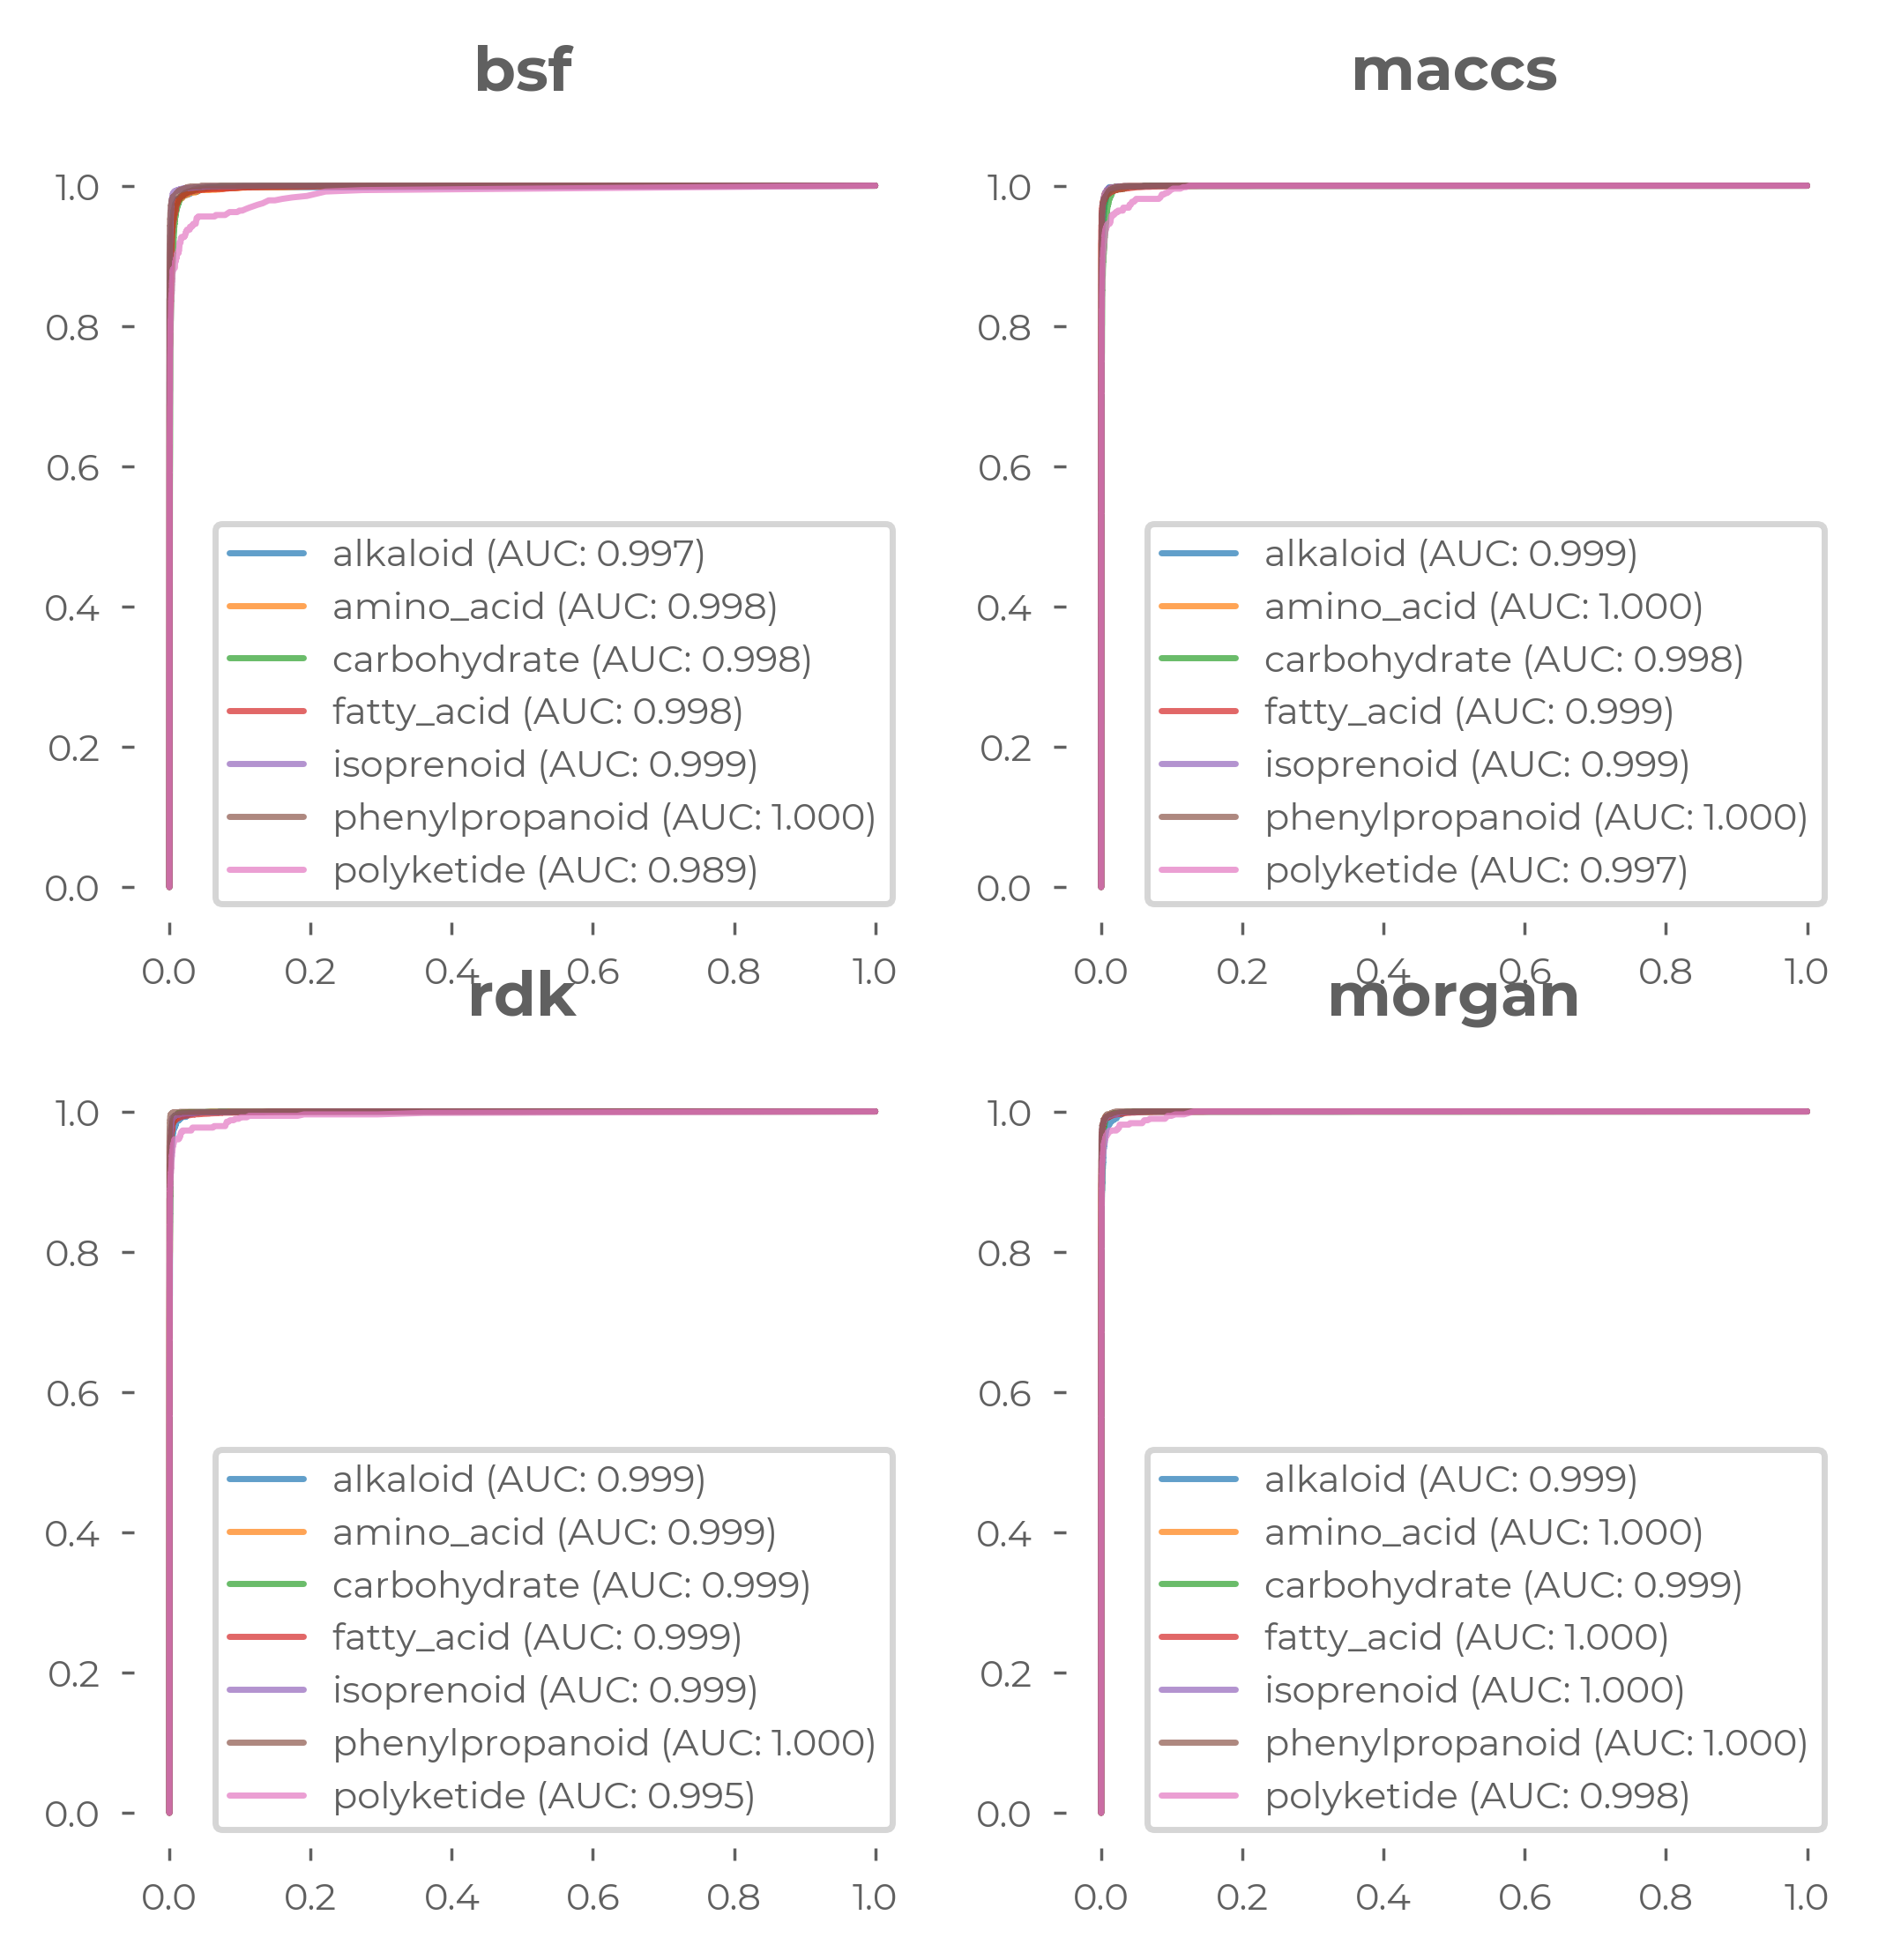

In [ ]:
import re
import numpy as np 
import pandas as pd

o_f = Path.home() / "article_bsf" / "output"
labels = np.loadtxt(o_f/"classifications.tsv", delimiter="\t", dtype=str)
def multilabel_and_dict(classifications: np.array) -> tuple[np.array, dict]:
    classes = set(";".join(map(str, classifications)).split(";"))
    class_to_id = {class_: i for i, class_ in enumerate(sorted(classes))}
    id_to_class = {i: class_ for class_, i in class_to_id.items()}
    classification_array = np.zeros((len(classifications), len(classes)), dtype=int)
    for i, classification in enumerate(classifications):
        for class_ in re.split(r"[;,]", classification):
            classification_array[i, class_to_id[class_]] = 1
    return classification_array, id_to_class

y_true, id_to_class = multilabel_and_dict(labels)

fig, ax = plt.subplots(2, 2, figsize=(5, 5))


df = pd.read_csv(o_f/"ids.tsv", sep="\t", dtype=str, header=None)
df["y_true"] = y_true.tolist()
for n, file in enumerate(o_f.glob("*_proba.tsv")):
    fp_name = file.stem.split("_")[0]
    df[f"y_proba_{fp_name}"] = np.loadtxt(file, delimiter="\t", dtype=float).tolist()
    df[f"y_pred_{fp_name}"] = df[f"y_proba_{fp_name}"].apply(lambda x: (np.array(x) > 0.5).astype(int).tolist())
    df["class"] = labels

    # get an ROC per class
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    auc=[]
    for i in range(y_true.shape[1]):
    =    print(id_to_class[i])
        fpr, tpr, roc = roc_curve(y_true[:, i], df[f"y_proba_{fp_name}"].apply(lambda x: x[i]))
        auc.append(roc_auc_score(y_true[:, i], df[f"y_proba_{fp_name}"].apply(lambda x: x[i])))
        ax[n // 2, n % 2].plot(fpr, tpr, label=f"{id_to_class[i]} AUC: {auc}", alpha=0.7)
        ax[n // 2, n % 2].set_title(fp_name)
    ax[n // 2, n % 2].legend(labels = [f"{id_to_class[i]} (AUC: {auc[i]:.3f})" for i in id_to_class.keys()], loc="lower right")

# Supplementary

## Figure 1 - Chemical space of datasets

In [92]:
from pathlib import Path


import pandas as pd
import numpy as np
from rdkit import Chem
import seaborn as sns

import umap



In [82]:

maccs_path = f"{Path().home()}/article_bsf/coconut_maccs.csv"
maccs = np.loadtxt(maccs_path, delimiter=",", dtype=int)
label = pd.read_csv(f"{Path().home()}/article_bsf/data/raw_data/coconut_complete-10-2024.csv")


/var/folders/qm/fzt72bc53hq6hhbj3wfljp5w0000gn/T/ipykernel_76892/2966178871.py:3: DtypeWarning: Columns (38,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  label = pd.read_csv(f"{Path().home()}/article_bsf/data/raw_data/coconut_complete-10-2024.csv")


In [104]:
# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
random_subset = np.random.choice(maccs.shape[0], 10000, replace=False)
subset_maccs = maccs[random_subset]
subset_labels = label.iloc[random_subset]


In [ ]:

embedding = reducer.fit_transform(subset_maccs)

<Axes: >

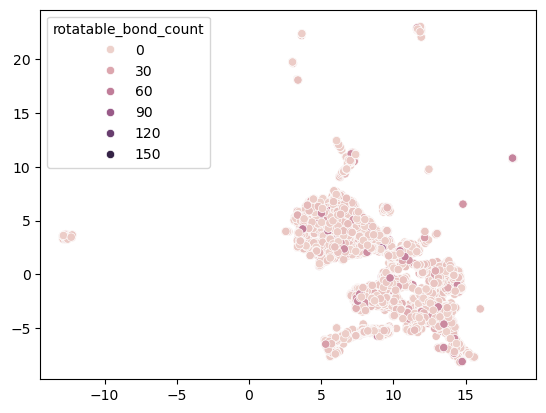

In [121]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=subset_labels["rotatable_bond_count"])#,  legend="full")

/Applications/anaconda3/envs/bsf_ext/lib/python3.12/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


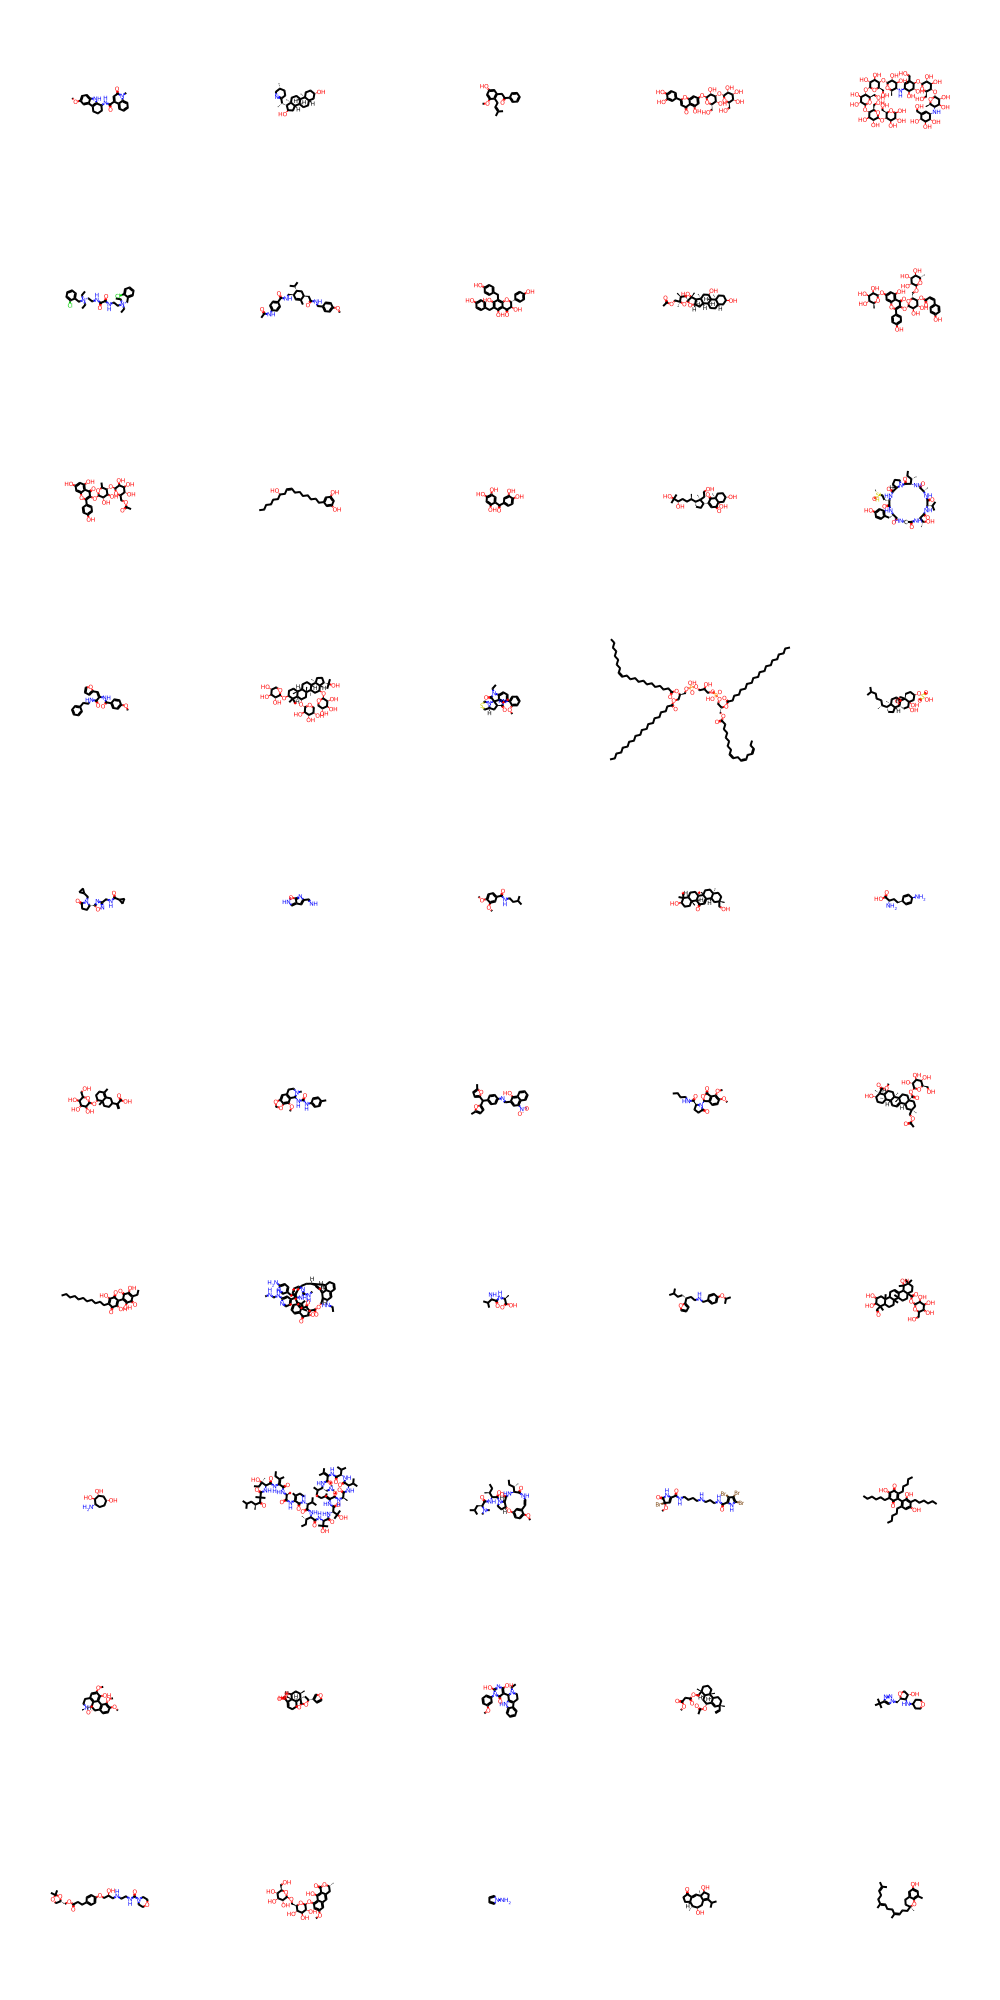

In [136]:
# get the indices of points that have embedding x < -10 and 0 < y < 5
points = embedding[(embedding[:, 0] < -10) & (0 < embedding[:, 1]) & (embedding[:, 1] < 5)]
indices = np.where((embedding[:, 0] < -10) & (0 < embedding[:, 1]) & (embedding[:, 1] < 5))[0]



of_interest = subset_labels.iloc[indices]

# draw molecules from smiles
mols = [Chem.MolFromSmiles(smiles) for smiles in of_interest["canonical_smiles"]]

Chem.Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))


In [52]:
# plot the molecules corresponding to the close points
sdf = Chem.SDMolSupplier(sdf_path)

for i, j in zip(*close_points):
    mol_i = sdf[int(random_subset[i][0])]
    mol_j = sdf[int(random_subset[j][0])]
    break
mol_i, mol_j

(<rdkit.Chem.rdchem.Mol at 0x1779a51c0>,
 <rdkit.Chem.rdchem.Mol at 0x1779a4e40>)

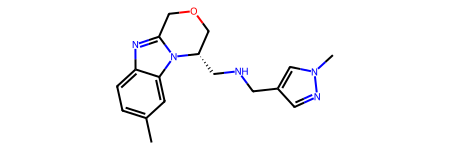

In [53]:
mol_i

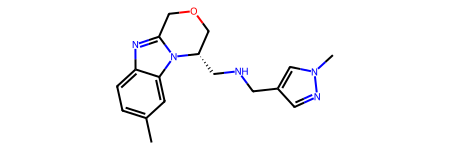

In [54]:
mol_j

## Figure 2 - Biosynthetic distance visualisations

In [ ]:
# # later for visualisation:

# def get_square(
#     df: pd.DataFrame,
#     col1: str,
#     col2: str,
#     range1: tuple[float, float],
#     range2: tuple[float, float],
# ) -> pd.DataFrame:
#     """returns the molecule pair's inchis for 'dots' in a given square of the scatter plot"""
#     square = df.loc[
#         (df[col1] >= range1[0])
#         & (df[col1] <= range1[1])
#         & (df[col2] >= range2[0])
#         & (df[col2] <= range2[1])
#     ]
#     return square


# def draw_molpair(
#     pair: list[Chem.Mol], annotation: str = "", highlighting: bool = True
# ) -> None:
#     for i in range(len(pair)):
#         highlighting_info = None
#         if highlighting:
#             highlighting_info = get_highlight_mapping(mol=pair[i])
#         svg_text = moldrawing.draw(
#             pair[i], highlight_atoms_bonds_mappings=highlighting_info
#         )
#         if annotation:
#             svg_text = svg_text.replace(
#                 "</svg>",
#                 f'<text x="30" y="30" font-size="20" font-family="montserrat">{annotation}</text></svg>',
#             )
#         with open(f"{annotation}_{i}.svg", "w") as f:
#             f.write(svg_text)
#     return None


# def draw_squares(
#     square_df: pd.DataFrame,
#     pair_columns: tuple[str, str] = ("mol1", "mol2"),
#     squarename: str = "origin",
#     highlighting: bool = True,
# ) -> None:
#     """draws the molecules in the squares
#     input: (pd.DataFrame) square_df -- the dataframe containing the squares
#     (str) pair_columns -- the name of the column containing the molecule pairs
#     (str) squarename -- the name of the square
#     """
#     if square_df.empty:
#         return None
#     for _, row in tqdm(
#         square_df.iterrows(),
#         desc=f"drawing {squarename} squares",
#         total=square_df.shape[0],
#         position=1,
#     ):
#         pair = [row[pair_columns[0]], row[pair_columns[1]]]
#         pathway = row["pathway"]
#         outfilename = outfile_namer(f"{squarename}_{pathway}")
#         draw_molpair(pair, annotation=outfilename, highlighting=highlighting)
#     return None


# def loopsquares(
#     df: pd.DataFrame,
#     x_fp: str = "biosynfoni",
#     y_fps: list[str] = ["rdkit", "maccs", "morgan"],
#     size: int = 0.2,
# ) -> None:
#     for i, y_fp in tqdm(
#         enumerate(y_fps), desc="looping squares", leave=False, position=0
#     ):
#         _, iwd = output_direr(f"./{x_fp}_{y_fp}_squares")
#         min_val, max_val = 0.0, 1.0
#         min_border = 0.0 + size
#         max_border = 1.0 - size
#         left_bottom = get_square(
#             df,
#             x_fp,
#             y_fp,
#             (min_val, min_border),
#             (min_val, min_border),
#         )
#         left_top = get_square(
#             df,
#             x_fp,
#             y_fp,
#             (min_val, min_border),
#             (max_border, max_val),
#         )
#         right_bottom = get_square(
#             df,
#             x_fp,
#             y_fp,
#             (max_border, max_val),
#             (min_val, min_border),
#         )
#         right_top = get_square(
#             df,
#             x_fp,
#             y_fp,
#             (max_border, max_val),
#             (max_border, max_val),
#         )
#         exactly_middle = get_square(
#             df,
#             x_fp,
#             y_fp,
#             (0.5, 0.5),
#             (min_val, max_val),
#         )
#         draw_squares(left_bottom, squarename=f"{y_fp}_origin")
#         draw_squares(left_top, squarename=f"{y_fp}_left_top")
#         draw_squares(right_bottom, squarename=f"{y_fp}_right_bottom")
#         draw_squares(right_top, squarename=f"{y_fp}_right_top")
#         if i == 0:
#             draw_squares(exactly_middle, squarename=f"{x_fp}_middle")
#         os.chdir(iwd)
#     return None


# def biosynthetic_distance_analysis(pairs_df, metric):
#     df = pd.read_csv(structures_path, sep="\t", header=None, index_col=0)
#     logging.info(
#         f"{old_n_rows[0]-df.shape[0]} pathways dropped due to lack of mol pairs\n\n"
#     )

#     _, iwd = output_direr("./biosynthetic_distance")  # move to outputdir

#     pairs = pairs_per_separation(df)

#     dist_df = f"{outfile_namer(metric)}.tsv"
#     mols_pkl = f"{outfile_namer('mols')}.pkl"
#     if not os.path.exists(dist_df) or not os.path.exists(mols_pkl):
#         df = add_fp_to_df(
#             pairs,
#             fp_types=FP_FUNCTIONS.keys(),
#         )
#         df = get_all_similarity_scores(df, metric=metric)
#         mols = df.copy()
#         # save mols as pickle
#         mols.to_pickle(f"{outfile_namer('mols')}.pkl")
#         # remove mols from df
#         df = df.drop(columns=["mol1", "mol2"])
#         df.to_csv(dist_df, sep="\t", index=True)

#     mols = pd.read_pickle(f"{outfile_namer('mols')}.pkl")
#     df = mols
#     df["pathway"] = df.index

#     logging.debug(df.shape, mols.shape, df.columns)
#     logging.debug(df, pairs, pairs.columns)

#     # if args.annotate:
#     #     # pw_tax_file = "../../../metacyc/pathways_taxid.txt"
#     #     # tax_text_file = "../../../metacyc/cleaner_classes.dat"
#     #     pw_tax_file, tax_text_file = args.annotate
#     #     annotated_df = annotate_pathways(comparison_df, pw_tax_file, tax_text_file)

#     df["stepnum"] = df["separation"].apply(str)

#     logging.info("getting scatterplots...")
#     fp_combs = list(itertools.combinations(fp_names, 2))
#     for combination in tqdm(fp_combs, desc="getting scatterplots"):
#         scatter = fm.scatter_boxplots(
#             df,
#             col_x=combination[0],
#             col_y=combination[1],
#             figtitle=f"{args.metric} for different reaction step numbers",
#             color_by="stepnum",
#         )
#         filename = outfile_namer(f"{combination[0]}_{combination[1]}_{args.metric}.png")
#         fm.savefig(scatter, filename)

#     onestep = df[df["stepnum"] == "1"]
#     onestep.to_csv(f'{outfile_namer("onestep")}.tsv', sep="\t", index=False)
#     logging.info("getting squares...")
#     for fp in [
#         "biosynfoni",
#         "overlap_binosynfoni",
#         "overlap_biosynfoni",
#         "interoverlap_biosynfoni",
#     ]:
#         loopsquares(
#             onestep,
#             fp,
#             ["rdkit", "maccs", "morgan", "maccsynfoni", "overlap"],
#             size=0.2,
#         )
#     # loopsquares(
#     #     onestep,
#     #     "biosynfoni",
#     #     ["rdkit", "maccs", "morgan", "maccsynfoni", "overlap"],
#     #     size=0.2,
#     # )

#     # save the biosynfoni version for reference
#     logging.info("saving current biosynfoni version...")
#     save_version(defaultVersion)

#     os.chdir(iwd)
#     logging.info("done\nbyebye")
#     exit(0)
#     return None


## Figure 3 - Fingerprint heatmaps

In [ ]:
# import sys, os, logging
# import argparse

# import numpy as np
# import matplotlib

# matplotlib.use("Agg")
# import matplotlib.pyplot as plt

# plt.ioff()


# from biosynfoni.inoutput import outfile_namer
# from biosynfoni.subkeys import fpVersions, defaultVersion, get_names, get_pathway
# from utils.figures import (
#     heatmap,
#     annotate_heatmap,
#     savefig,
#     set_label_colors_from_categories,
#     custom_cmap,
# )
# from utils import set_style
# from utils.colours import colourDict


# def cli():
#     """Command line interface for fingerprint average plotter"""
#     parser = argparse.ArgumentParser(
#         description="Plot fingerprint pull-up plot (i.e. fingerprint count per substructure)"
#     )
#     # parser.add_argument("fingerprintfile_coco", type=str)
#     # parser.add_argument("fingerprintfile_zinc", type=str)
#     # parser.add_argument("bsf_name", type=str, default=defaultVersion)
#     parser.add_argument(
#         "fingerprints", type=str, help="path to tsv or csv file of fingerprints"
#     )
#     parser.add_argument(
#         "-n",
#         "--name",
#         type=str,
#         help="name of compound collection for title and filename",
#     )
#     parser.add_argument(
#         "-c",
#         "--classes",
#         type=str,
#         required=False,
#         help="path to tsv or csv file of classes, uses first column as class label. pass if you want to also plot classes separately",
#     )
#     args = parser.parse_args()
#     args.fingerprints = os.path.abspath(args.fingerprints)
#     args.classes = os.path.abspath(args.classes) if args.classes else None
#     return args


# def count_distributions(coco, zinc, substructure_names):
#     """WIP: Plots substructure count distribution for coco and zinc"""
#     npcs = np.loadtxt(
#         "npcs.tsv", dtype="str", delimiter="\t"
#     )  # just added, not checked
#     s_coco = coco[npcs[:, 0] == "Alkaloids"]
#     # random subsample of zinc
#     np.random.seed(42)
#     s_zinc = zinc[np.random.choice(zinc.shape[0], size=s_coco.shape[0], replace=False)]

#     for i in range(3, len(substructure_names)):
#         # np.histogram(coco[:,i])
#         # print(np.mean(coco[:,i]))
#         fig = plt.figure()
#         nonzero = s_coco[:, i][s_coco[:, i] > 0]
#         if np.max(nonzero) == 0:
#             continue
#         n, bins, edges = plt.hist(
#             nonzero,
#             bins=np.max(nonzero) - 1,
#             color="green",
#             alpha=0.7,
#             histtype="step",
#             align="left",
#         )

#         plt.title(
#             f"substructure counts for {substructure_names[i]}, {len(nonzero)} nonzero values"
#         )
#         plt.xticks(bins)
#         plt.xlabel("substructure counts")
#         plt.ylabel("number of compounds")
#         plt.tight_layout()

#     for i in range(3, len(substructure_names)):
#         # np.histogram(coco[:,i])
#         # print(np.mean(zinc[:,i]))
#         fig = plt.figure()
#         nonzero = s_zinc[:, i][s_zinc[:, i] != 0]
#         if np.max(nonzero) < 2:
#             continue
#         n, bins, edges = plt.hist(
#             nonzero,
#             bins=np.max(nonzero) - 1,
#             color="purple",
#             alpha=0.7,
#             rwidth=1,
#             histtype="step",
#             align="mid",
#         )
#         plt.title(
#             f"histogram of substructure counts for {substructure_names[i]}, {len(nonzero)} nonzero values"
#         )
#         plt.xticks(bins)
#         plt.xlabel("substructure counts")
#         plt.ylabel("number of compounds")

#     plt.close()
#     return None


# def write_stats(fp_arr: np.array) -> np.array:
#     """
#     Write stats of fingerprint array to file

#         Args:
#             fp_arr (np.array): fingerprint array

#         Returns:
#             np.array: mean fingerprint count per substructure
#     """
#     mean_fp = fp_arr.mean(axis=0)
#     std_fp = fp_arr.std(axis=0)
#     median_fp = np.median(fp_arr, axis=0)
#     with open("stats.tsv", "w") as f:
#         f.write("mean\n")
#         f.write("\t".join([str(x) for x in mean_fp]))
#         f.write("\nstdev\n")
#         f.write("\t".join([str(x) for x in std_fp]))
#         f.write("\nmedian\n")
#         f.write("\t".join([str(x) for x in median_fp]))
#     return mean_fp


# def heatmap_array(
#     fps: np.array,
#     max_height: int = 30,
#     percentages=False,
#     accumulative=True,
#     end_accumulative=False,
# ):
#     """
#     Make an array for a heatmap of fingerprint count per substructure

#         Args:
#             fps (np.array): fingerprint array
#             max_height (int): maximum height of heatmap
#             percentages (bool): whether to return in percentages
#             accumulative (bool): whether to return accumulative counts
#             end_accumulative (bool): whether to return accumulative counts only for the last height
#         Returns:
#             np.array: array for heatmap (height x substructures)

#     Remarks:
#         - if accumulative is True, then the heatmap will show the number of compounds that have at least that many substructures
#         - if accumulative is False, then the heatmap will show the number of compounds that have exactly that many substructures
#         - if end_accumulative is True, then the heatmap will show the number of compounds that have at least that many substructures for the last height

#     """
#     heat_array = np.zeros((max_height, fps.shape[1]))
#     for i in range(max_height):
#         if accumulative:
#             countrow = np.count_nonzero(fps > i, axis=0)
#         else:
#             if end_accumulative and i == max_height - 1:
#                 # for last height, count all remaining values
#                 countrow = np.count_nonzero(fps > i, axis=0)
#             else:
#                 countrow = np.count_nonzero((fps == i + 1), axis=0)
#         heat_array[max_height - 1 - i] = countrow

#     if percentages:
#         heat_array = heat_array / fps.shape[0] * 100
#     return heat_array.astype(int)


# def fp_heatmap(
#     fp_hm_array: np.array,
#     subslabels: list = [],
#     size: tuple[int] = (10, 6),
#     percentages: bool = False,
#     annotate: bool = False,
#     color_scheme: str = "Purples",
#     title: str = "Representative substructure count for compound collection",
#     top_acc_array=None,
#     standard_colour: bool = False,
# ):
#     """
#     Plot a heatmap of fingerprint count per substructure

#         Args:
#             fp_hm_array (np.array): array for heatmap (height x substructures)
#             subslabels (list): list of substructure labels
#             size (tuple): size of plot
#             percentages (bool): whether to return in percentages
#             annotate (bool): whether to annotate the heatmap
#             color_scheme (str): colour scheme for heatmap
#             title (str): title of plot
#             top_acc_array (np.array): array for heatmap of top accumulative counts.
#                                         if None, then no top accumulative counts will be plotted.
#                                         default is None.
#             standard_colour (bool): whether to colour substructure labels according to biosynfoni pathway
#         Returns:
#             matplotlib.figure.Figure: figure of heatmap
#     """
#     cbarlab = "number of compounds"
#     if percentages:
#         cbarlab = "% of compounds"

#     logging.info("saving heatmap")
#     height = fp_hm_array.shape[0]
#     fig, ax = plt.subplots(figsize=size, dpi=500)
#     if not subslabels:
#         subslabels = [f"subs{i}" for i in range(1, fp_hm_array.shape[1] + 1)]
#     subslabels = [x.replace("_", " ") for x in subslabels]

#     yaxlabels = [(height + 1 - i) for i in range(1, height + 1)]
#     if top_acc_array is not None:
#         yaxlabels[0] = f"≥{height}"
#         maxtop = top_acc_array[~np.isnan(top_acc_array)].max()
#         maxfp = fp_hm_array[~np.isnan(fp_hm_array)].max()
#         maxval = max(maxtop, maxfp)
#         im2, cbar2 = heatmap(
#             top_acc_array,
#             # ['>11']+[(height+1-i) for i in range(1, height + 1)],
#             yaxlabels,
#             subslabels,
#             ax=ax,
#             cmap=custom_cmap("Greys", first_color="#ffffff00"),
#             # cmap = "PiYG",
#             cbar_kw={
#                 "drawedges": False,
#                 "shrink": 0.3,
#                 "pad": -0.05,
#                 "aspect": 10,
#             },
#             vmin=0,
#             vmax=maxval,
#         )
#         # rotate cbar labels -90
#         cbar2.set_label(f"{cbarlab} ≥{height}", rotation=90, va="bottom", labelpad=10)

#     im, cbar = heatmap(
#         fp_hm_array,
#         # [(height+1-i) for i in range(1, height + 1)],
#         yaxlabels,
#         subslabels,
#         ax=ax,
#         cmap=custom_cmap(color_scheme, first_color="#ffffff00"),
#         # cmap = "PiYG",
#         cbarlabel=cbarlab,
#         vmin=0,
#         cbar_kw={"drawedges": False, "shrink": 0.3, "pad": 0.02, "aspect": 10},
#     )
#     cbar.set_label(f"{cbarlab}", rotation=90, va="bottom", labelpad=10)

#     # texts = annotate_heatmap(im, valfmt="{x:.1f}")
#     if annotate:
#         texts = annotate_heatmap(im, valfmt="{x:.0f}", size=7)
#     if standard_colour:
#         set_label_colors_from_categories(
#             ax.get_xticklabels(),
#             get_pathway(version=defaultVersion),
#             colourDict["pathways"],
#         )
#     # plt.figure(figsize=(10,6))
#     ax.set_xlabel("substructure", labelpad=10)
#     ax.set_ylabel("counts", labelpad=10)
#     ax.set_title(title, loc="center", pad=20)
#     fig.tight_layout()
#     return fig


# def over_under_divide(fps: np.array, limit: int = 10, percentages: bool = True):
#     """
#     Divide the heatmap array into two arrays: one for values under the limit, and one for values over the limit.
#     """
#     full = heatmap_array(
#         fps,
#         max_height=limit + 1,
#         percentages=percentages,
#         accumulative=False,
#         end_accumulative=True,
#     )
#     under, over = full.astype(float).copy(), full.astype(float).copy()
#     under[0] = np.nan
#     over[1:] = np.nan
#     return under, over


# def fp_heatmap_accumulative(fp_arr: np.array, limit: int = 10, *args, **kwargs):
#     """
#     Make a heatmap of fingerprint count per substructure, with accumulative end counts

#         Args:
#             fp_arr (np.array): fingerprint array
#             limit (int): maximum height of heatmap
#         Returns:
#             matplotlib.figure.Figure: figure of heatmap

#     Remarks:
#         - the heatmap will show the number of compounds that have at least that many substructures for the last height
#         - this helps reduce the height of the heatmap, as the top accumulative counts are often much higher than the rest
#     """
#     under, over = over_under_divide(fp_arr, limit, percentages=True)
#     hm = fp_heatmap(
#         under,
#         *args,
#         percentages=True,
#         top_acc_array=over,
#         **kwargs,
#     )
#     return hm


# def main():
#     logging.info("hello")
#     set_style()
#     ft = "png"
#     args = cli()
#     fps = np.loadtxt(args.fingerprints, dtype=int, delimiter=",")

#     fp_name = "_".join(args.fingerprints.split("/")[-1].split(".")[0].split("_")[1:])
#     set_name = args.fingerprints.split("/")[-1].split(".")[0].split("_")[0]

#     iwd = os.getcwd()
#     os.makedirs(f"{iwd}/heatmaps/{set_name}/{fp_name}", exist_ok=True)
#     os.chdir(f"{iwd}/heatmaps/{set_name}/{fp_name}")
#     fp_name = fp_name.replace("_", " ")

#     # save mean, std, median, etc of fps
#     write_stats(fps)

#     substructure_names = get_names(version=defaultVersion)
#     if fps.shape[1] != len(substructure_names):
#         substructure_names = [f"{i}" for i in range(1, fps.shape[1] + 1)]

#     # if all values in fps are 0 or 1, then it's a binary fingerprint
#     if np.all(np.isin(fps, [0, 1])):
#         fp_heatmap(
#             heatmap_array(fps, max_height=1, percentages=True, accumulative=False),
#             subslabels=substructure_names,
#             title=f"Distribution of {fp_name} substructure counts",
#             color_scheme="Greys",
#             percentages=True,
#             size=(15, 1),
#             standard_colour=True,
#         )
#         plt.savefig(f"{fp_name}_heatmap.{ft}")
#         return None

#     hm = fp_heatmap_accumulative(
#         fps,
#         limit=10,
#         title=f"Distribution of {fp_name} substructure counts",
#         subslabels=substructure_names,
#         color_scheme="GnBu",
#         standard_colour=True,
#     )
#     savefig(hm, f"heatmap.{ft}")

#     if args.classes:
#         classes = np.loadtxt(args.classes, dtype="str", delimiter="\t", usecols=0)
#         classes[classes == "fatty_acid,isoprenoid"] = "isoprenoid"
#         classes = np.where(
#             np.core.defchararray.find(classes, ",") != -1, "multiple", classes
#         )
#         classes[classes == ""] = "None"

#         if len(classes) != fps.shape[0]:
#             logging.warning(
#                 "classes file not same length as fingerprints file; will lead to errors"
#             )
#         for classif in np.unique(classes):
#             idx = np.where(classes == classif)
#             focus = fps[idx]
#             if not classif:
#                 classif = "None"

#             hm = fp_heatmap_accumulative(
#                 focus,
#                 limit=10,
#                 title=f"Distribution of {fp_name} substructure counts for {len(focus)} {classif.replace('_', ' ')} compounds",
#                 subslabels=substructure_names,
#                 color_scheme="GnBu",
#                 standard_colour=True,
#             )
#             savefig(hm, f"{classif}_heatmap.{ft}")

#     os.chdir(iwd)
#     # fp_means_plots(coco_mean, zinc_mean, outfile_namer(f"{coco_name}_{zinc_name}.svg"))


# if __name__ == "__main__":
#     main()


## Figure 4 - Clustermaps

In [ ]:
# import sys, os, argparse, logging

# import numpy as np
# import seaborn as sns
# import scipy.cluster.hierarchy as sch
# import matplotlib as mpl
# import matplotlib.pylab as plt
# from matplotlib.patches import Patch
# import pandas as pd
# from tqdm import tqdm

# # matplotlib.use('Agg')       #if in background

# from biosynfoni.subkeys import get_names, get_pathway
# from utils import set_style
# from utils.colours import colourDict
# from utils.figures import set_label_colors_from_categories


# def cli():
#     """
#     Command line interface for clustermap
#     """
#     parser = argparse.ArgumentParser()

#     parser.add_argument("fingerprints", help="Fingerprint file")
#     parser.add_argument("labels", help="Labels file")
#     parser.add_argument(
#         "-s",
#         "--subsample",
#         required=False,
#         type=int,
#         help="subsample size",
#         default=None,
#     )
#     parser.add_argument(
#         "-r",
#         "--seed",
#         "--randomseed",
#         required=False,
#         type=int,
#         help="seed for subsampling",
#         default=None,
#     )

#     args = parser.parse_args()
#     args.fingerprints = os.path.abspath(args.fingerprints)
#     args.labels = os.path.abspath(args.labels)
#     return args


# class recursion_depth:
#     def __init__(self, limit):
#         self.limit = limit
#         self.default_limit = sys.getrecursionlimit()

#     def __enter__(self):
#         sys.setrecursionlimit(self.limit)

#     def __exit__(self, type, value, traceback):
#         sys.setrecursionlimit(self.default_limit)


# class ClusterMap:
#     def __init__(self, df, labels, metric, method) -> None:
#         self.df = df
#         self.indexes = df.index.values
#         self.labels = labels
#         self.colordict = self.get_colordict()
#         self.metric = metric
#         self.method = method
#         logging.debug(f"calculating distances with {metric} and {method}...")
#         self.distances = self.get_distances()
#         self.clustering = self.get_clustering()
#         # self.distances = None
#         # self.clustering = None
#         # self.tree = self.get_tree()
#         self.colors, self.handles = self._get_category_colors_handles(self.labels)
#         logging.debug(f"plotting clustermap with {metric} and {method}...")
#         self.clustermap = self.seacluster()
#         self.clusterfig = self.get_clusterplot()
#         plt.close()
#         pass

#     def get_distances(self):
#         """
#         calculates distances from data frame using metric
#         """
#         return sch.distance.pdist(self.df, metric=self.metric)

#     def set_distances(self, distances):
#         """
#         sets distances from data frame
#         """
#         self.distances = distances
#         return None

#     def get_clustering(self):
#         """
#         calculates clustering from distances using method
#         """
#         # plt.title(out_file)
#         with recursion_depth(10000):
#             clustering = sch.linkage(self.distances, method=self.method)
#         # plt.close()
#         return clustering

#     def get_tree(self):
#         """returns dendrogram tree"""
#         tree = sch.dendrogram(
#             self.clustering, leaf_font_size=2, color_threshold=4, labels=self.indexes
#         )
#         return tree

#     def seacluster(self):
#         """
#         Makes a seaborn clustermap

#         Returns:
#         seacluster: seaborn clustermap object
#         """
#         # comp_color, comp_handles = get_gnsr_diff_color() #compounds

#         cmap = _cmap_makezerowhite("mako")

#         # self.distances = self.set_distances(self.get_distances())
#         # self.clustering = self.get_clustering()
#         # fig, ax = plt.subplots(figsize=(15,6))
#         # sns.set(font_scale=0.5)
#         with recursion_depth(20000):
#             seacluster = sns.clustermap(
#                 self.df,
#                 method=self.method,
#                 metric=self.metric,
#                 xticklabels=1,  # every 1: label
#                 # robust = True,
#                 # square = True,
#                 row_colors=self.colors,
#                 # col_colors = phyl_color,
#                 # z_score = 1,
#                 # figsize= (len(list(data_frame)), min(200, len(data_frame.index.values))),
#                 cmap=cmap,
#                 cbar_kws={
#                     "shrink": 0.3,
#                     "label": "counts",
#                     # "orientation": "horizontal",
#                     # "labelweight": "bold",
#                 },
#                 cbar_pos=(1.05, 0.2, 0.03, 0.4),
#             )
#         # make x tick labels bold

#         return seacluster

#     def get_clusterplot(self, legend_title: str = "class") -> plt.gca:
#         """returns plt of clustermap with legend of categories"""

#         # plt.figure(figsize=(15,6))

#         # plt.setp(seacluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#         # plt.setp(seacluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=30, fontsize=8)
#         # plt.setp(seacluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=-30)
#         # seacluster.set_xlim([0,2])

#         # seacluster.set_title(TITLE, fontsize=16, fontdict={})
#         # plt.title(
#         #     f"Hierarchical clustering of compounds and substructures {self.method}, {self.metric}",
#         #     loc="center",
#         # )  # + 'z scored')
#         self.clustermap.fig.suptitle(
#             f"Hierarchical clustering of compounds and substructures {self.method}, {self.metric}",
#             x=0.6,
#             y=1.1,
#             weight="bold",
#             size=18,
#         )
#         self.clustermap.ax_heatmap.set_xticklabels(
#             self.clustermap.ax_heatmap.get_xmajorticklabels(),
#             fontsize=10,
#             fontweight="semibold",
#         )
#         self._set_substructure_colours()

#         # seacluster = self.seacluster()

#         # improve layout
#         # plt.tight_layout()

#         # add legend
#         handles = self.handles
#         legend_colors = [
#             Patch(facecolor=handles[name], edgecolor="#FFFFFF00")
#             for name in handles.keys()
#         ]

#         plt.legend(
#             legend_colors,
#             handles.keys(),
#             title=legend_title,
#             bbox_to_anchor=(1, 0.9),
#             bbox_transform=plt.gcf().transFigure,
#             loc="upper left",
#             frameon=False,
#             edgecolor="#FFFFFF",
#             fontsize=10,
#         )
#         # set legend title size
#         plt.setp(plt.gca().get_legend().get_title(), fontsize=10)

#         # plt.show()
#         # return dendrogram_linkage
#         return plt.gca()

#     def save_clustermap(self, fmt: str = "svg") -> None:
#         """saves clustermap to file

#         Args:
#             fmt: str, file format
#         Returns:
#             None
#         """
#         out_file = f"clustermap_{self.method}_{self.metric}.{fmt}"
#         # self.clusterfig.savefig(out_file, format=fmt)
#         self.clustermap.savefig(out_file, format=fmt)
#         # plt.savefig(out_file, format=fmt)
#         return None

#     def get_dendogram_tree(self):
#         """returns dendrogram tree object for branch cutting"""
#         return self.clustermap.dendrogram_row.dendrogram

#     def get_dendogram_linkage(self) -> np.ndarray:
#         """returns dendrogram linkage object"""
#         return self.clustermap.dendrogram_row.linkage

#     def get_colordict(self) -> dict:
#         """returns colour dictionary for categories
#         Returns:
#             colordict: dict, category: color
#         """
#         # colordict = {
#         #     "Terpenoids": sns.color_palette("Set3")[6],  # green
#         #     "Alkaloids": sns.color_palette("Set3")[9],  # purple
#         #     "Shikimates and Phenylpropanoids": sns.color_palette("Set3")[4],  # blue
#         #     "Fatty acids": sns.color_palette("Set3")[5],  # orange
#         #     "Carbohydrates": sns.color_palette("Set3")[7],  # pink
#         #     "Polyketides": sns.color_palette("Set3")[3],  # light red
#         #     "Amino acids and Peptides": "bisque",
#         #     # "No NP-Classifier prediction": "grey",
#         #     "None": "grey",
#         #     "Synthetic": "black",
#         # }
#         if self.labels[0][0].isupper():
#             colordict = colourDict["NPClassifier prediction"]
#         else:
#             colordict = colourDict["chebi class"]
#         return colordict

#     def _get_category_colors_handles(
#         self, categories: pd.Series
#     ) -> tuple[pd.DataFrame, dict]:
#         """uses colour dictionary to assign colors to the categories"""
#         network_dict = {}
#         categories.fillna("None", inplace=True)

#         for ind, cat in categories.items():
#             # network_dict[ind] = [self.colordict[str(cat).split(',')[0]]] #in case of multiple categories, take the first one
#             network_dict[ind] = [self.colordict[str(cat)]]
#         network_colors = pd.DataFrame.from_dict(network_dict, orient="index")
#         network_colors.columns = [""]
#         handles = self.colordict
#         return network_colors, handles

#     def _set_substructure_colours(self):
#         """sets substructure colours in clustermap"""
#         pathways = get_pathway()
#         substructures = self.df.columns
#         subs_to_pathways = {a: b for a, b in zip(substructures, pathways)}
#         ticklabels = self.clustermap.ax_heatmap.get_xticklabels()
#         # access text from ticklabels
#         pathways = [subs_to_pathways[x.get_text()] for x in ticklabels]
#         if len(pathways) != len(ticklabels):
#             logging.warning(
#                 f"cannot set {pathways} substructure for {ticklabels} colours"
#             )
#             return None
#         else:
#             set_label_colors_from_categories(
#                 ticklabels, pathways, colourDict["pathways"]
#             )


# def _cmap_makezerowhite(
#     default_cmap: str = "mako",
# ) -> mpl.colors.LinearSegmentedColormap:
#     # define color map:-------------------------------------------------
#     cmap = sns.color_palette(default_cmap, as_cmap=True)  # define the colormap
#     # extract all colors from the .jet map
#     cmaplist = [cmap(i) for i in range(cmap.N)]
#     # force the first color entry to be white (to distinguish 0 from low values)
#     cmaplist[0] = (1.0, 1.0, 1.0, 0)
#     # create the new map
#     cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)
#     return cmap


# def main():
#     set_style()
#     args = cli()

#     filetype = "svg"
#     # version = input_file.split("/")[-1].split("_")[-1].split(".")[0]
#     substructure_names = [x.replace("_", " ") for x in get_names()]

#     fp = pd.read_csv(args.fingerprints, sep=",", header=None, dtype=int)
#     if fp.shape[1] == len(substructure_names):
#         fp.columns = substructure_names
#     db_name = args.fingerprints.split("/")[-1].split(".")[0].split("_")[0]
#     fp_name = args.fingerprints.split("/")[-1].split(".")[0].split("_")[1]

#     npcs = pd.read_csv(
#         args.labels,
#         sep="\t",
#         header=None,
#         dtype=str,
#         usecols=[0],
#     )

#     # as all isoprenoids are fatty acids according to chebi:
#     npcs.replace("fatty_acid,isoprenoid", "isoprenoid", inplace=True)
#     # filter out multiple-prediction compounds
#     npcs.fillna(",", inplace=True)
#     fp = fp[~npcs[0].str.contains(",")]
#     npcs = npcs[~npcs[0].str.contains(",")]

#     # # filter out only-zero columns in df ~~~~~~~~~~~~~~~ CHECK IF THIS APPLIES TO YOUR PURPOSES ~~~~~~~~~~~~~~~
#     # fp = fp.loc[:, (fp != 0).any(axis=0)]
#     # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#     # subsample indexes
#     if args.subsample:
#         np.random.seed(args.seed)
#         idx = np.random.choice(fp.index, args.subsample, replace=False)
#         fp = fp.loc[idx]
#         npcs = npcs.loc[idx]

#     npcs_series = npcs.iloc[:, 0]

#     # check if indexes are the same
#     assert fp[fp.index != npcs.index].empty
#     assert npcs[npcs.index != npcs_series.index].empty
#     assert type(npcs_series) == pd.Series

#     # if args.synthetic: #under construction
#     #     synthetic_fp = pd.read_csv(args.synthetic, dtype=int)
#     #     synthetic_fp = np.random.choice(
#     #         synthetic_fp.shape[0], fp.shape[0], replace=False
#     #     )
#     #     fp = np.concatenate((fp, synthetic_fp))
#     #     synthetic_labels = np.array(["synthetic" for _ in range(synthetic_fp.shape[0])])
#     #     labels = np.concatenate((labels, synthetic_labels))

#     iwd = os.getcwd()
#     # make a directory in grandparent directory called clustermaps
#     # os.chdir("../../")
#     os.makedirs(f"clustermaps/{db_name}/{fp_name}", exist_ok=True)
#     os.chdir(f"clustermaps/{db_name}/{fp_name}")

#     # # debugging
#     # clustermap = ClusterMap(fp, npcs_series, "euclidean", "average")
#     # clustermap.save_clustermap(fmt=filetype)

#     for method in tqdm(["average", "complete", "single", "weighted"]):
#         for metric in tqdm(
#             [
#                 "euclidean",
#                 "cityblock",
#                 "cosine",
#                 "correlation",
#                 "hamming",
#                 "jaccard",
#                 "mahalanobis",
#                 "chebyshev",
#                 "canberra",
#                 "braycurtis",
#                 "dice",
#                 "kulsinski",
#                 "matching",
#                 "rogerstanimoto",
#                 "russellrao",
#                 "sokalmichener",
#                 "sokalsneath",
#                 "yule",
#             ],
#             leave=False,
#         ):
#             # errors can occur for some metrics if they have too small sample sets, or with certain combinations:
#             try:
#                 clustermap = ClusterMap(fp, npcs_series, metric, method)
#                 clustermap.save_clustermap(fmt=filetype)
#             except:
#                 logging.warning(f"failed for {method} and {metric}")
#             pass
#         pass

#     os.chdir(iwd)
#     return None


# if __name__ == "__main__":
#     main()


## Figure 5 - Importances Classification

In [ ]:
# from sys import argv

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from biosynfoni.subkeys import defaultVersion, get_values, get_pathway
# from utils.figures import cat_to_colour
# from utils.colours import colourDict
# from utils import set_style


# def main():
#     """
#     Plot the feature importances from a random forest model as a barplot
#     """
#     importances = np.loadtxt(argv[1], delimiter="\t", dtype=float)
#     bsf_name = defaultVersion
#     substructure_names = get_values("name", version=bsf_name)
#     pathways = get_pathway(version=bsf_name)
#     colors = cat_to_colour(pathways, colourDict["pathways"])
#     if len(substructure_names) != importances.shape[1]:
#         print("WARNING: substructure names not equal to importances")
#         substructure_names = [f"{i}" for i in range(importances.shape[1])]
#         colors = ["#888888" for _ in range(importances.shape[1])]
#     set_style()

#     means = np.mean(importances, axis=0)

#     # set plot size
#     # default: 6.4, 4.8
#     ratio = importances.shape[1] / 39
#     plt.figure(figsize=(ratio * 6.4, 4.8))

#     # plot barplot
#     barplot = plt.bar(substructure_names, means)
#     # add standard deviations as error bars
#     stds = np.std(importances, axis=0)
#     print(stds.shape)
#     e1 = plt.errorbar(substructure_names, means, yerr=stds, fmt="o", color="#606060")
#     e2 = plt.errorbar(substructure_names, means, yerr=stds, fmt="none", color="#606060")

#     plt.xticks(range(len(substructure_names)), substructure_names, rotation=90)
#     # set bar colours
#     for i, bar in enumerate(barplot):
#         bar.set_color(colors[i])

#     plt.xticks(rotation=90)
#     plt.ylabel("feature importance")
#     plt.xlabel("substructure")
#     plt.suptitle("Feature importances for random forest model", weight="bold")
#     plt.title("(averaged over k-fold cross validation with k=5)", weight="light")
#     plt.tight_layout()
#     plt.savefig(argv[1].replace(".tsv", ".png"), bbox_inches="tight")
#     return None


# if __name__ == "__main__":
#     main()


## Figure 6 - Confusion Matrix heatmaps

In [ ]:
# import argparse, logging
# import os

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import numpy as np


# def set_style() -> None:
#     """
#     Set the style of the plot to biostylefoni
#     """
#     # get path of this script
#     script_path = os.path.dirname(os.path.realpath(__file__))
#     parent_path = os.path.dirname(script_path)
#     utils_path = os.path.join(parent_path, "utils")
#     print(utils_path)
#     style_path = os.path.join(utils_path, "biostylefoni.mplstyle")
#     # set style
#     plt.style.use(style_path)
#     return None


# def parse_cms_files(m_path: str) -> tuple[np.array, np.array]:
#     """
#     Parse the confusion matrices and names from a file

#     Args:
#         m_path (str): path to file with confusion matrices

#     Returns:
#         tuple[np.array, np.array]: array of confusion matrices and array of names (i.e. )
#     """
#     cms = np.loadtxt(
#         m_path,
#         delimiter="\t",
#         dtype=int,
#         skiprows=1,
#         usecols=(1, 2, 3, 4),
#     )
#     # for each row, split the array into a 2x2 array
#     cms = cms.reshape(cms.shape[0], 2, 2)

#     # now get only the 'index names'
#     cm_names = np.loadtxt(
#         m_path,
#         delimiter="\t",
#         dtype=str,
#         skiprows=1,
#         usecols=(0),
#     )
#     return cms, cm_names


# def get_matrices(cms: np.array) -> tuple[list[np.array], list[np.array]]:
#     """
#     Take an array of confusion matrices and return a list of matrices and a list of normalised matrices

#     Args:
#         cms (np.array): array of confusion matrices

#     Returns:
#         tuple[list[np.array], list[np.array]]: a list of matrices and a list of normalised matrices
#     """
#     matrices = []
#     norm_matrices = []
#     perc_matrices = []
#     for i in range(cms.shape[0]):
#         # # make random matrix with values between 0 and 100000
#         # matrix = np.random.randint(0, 100000, size=(2, 2))
#         matrix = cms[i]
#         # normalise matrix
#         norm_matrix = matrix / matrix.sum(axis=1, keepdims=True)
#         # turn normalised matrix into percentages
#         perc_matrix = norm_matrix * 100
#         # append matrices to list
#         matrices.append(matrix)
#         norm_matrices.append(norm_matrix)
#         perc_matrices.append(perc_matrix)
#     assert len(matrices) == len(perc_matrices), "#matrices don't match"
#     return matrices, perc_matrices


# def main(matrix_path, ):
#     matrix_path = Path(matrix_path)
#     ml_input = matrix_path.stem.split("_")[-1]

#     # read in the confusion matrix and names
#     cms, cm_names = parse_cms_files(matrix_path)
#     # print(cms, cm_names)

#     # get the matrices and the percentage versions for each category
#     matrices, perc_matrices = get_matrices(cms)
#     assert len(matrices) == len(cm_names), "#matrices and #categories don't match"

#     # make subplots
#     fig, axs = plt.subplots(
#         1, len(matrices), figsize=(len(matrices), 2), dpi=500
#     )  # , sharey=True) #sharing y makes the y axis ticks appear in each subplot

#     # make a heatmap in each subplot
#     for i, ax in enumerate(axs):
#         cmap_name = "Greys"
#         cmap = mpl.colormaps[cmap_name]
#         # plot heatmap
#         im = ax.imshow(perc_matrices[i], cmap=cmap_name, vmin=0, vmax=100)
#         # remove ticks
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         # set title
#         title = cm_names[i].replace("_", "\n")
#         axtitle = ax.set_title(title, fontsize=7, fontweight=600, wrap=True)
#         # force the wrap line width to be shorter
#         axtitle._get_wrap_line_width = lambda: 600.0  #  wrap to 600 screen pixels
#         # annotate values in each box, with dark text for light background and light text for dark background
#         fontweight = 500
#         a_size = 5
#         for j in range(2):
#             for k in range(2):
#                 if perc_matrices[i][j][k] < 50:
#                     text = ax.text(
#                         k,
#                         j,
#                         f"{round(matrices[i][j][k], 2)}\n({round(perc_matrices[i][j][k], 2)}%)",
#                         ha="center",
#                         va="center",
#                         color=cmap(1.0),
#                         fontsize=a_size,
#                         fontweight=fontweight,
#                     )
#                 else:
#                     text = ax.text(
#                         k,
#                         j,
#                         # round(matrices[i][j][k], 2),
#                         f"{round(matrices[i][j][k], 2)}\n({round(perc_matrices[i][j][k], 2)}%)",
#                         ha="center",
#                         va="center",
#                         color=cmap(0.0),
#                         fontsize=a_size,
#                         fontweight=fontweight,
#                     )

#     # set ticks
#     axs[0].set_yticks([0, 1])
#     axs[0].set_yticklabels(["P", "N"], fontsize=6, fontweight=500)
#     axs[0].set_xticks([0, 1])
#     axs[0].set_xticklabels(["P", "N"], fontsize=6, fontweight=500)

#     # set y label
#     axs[0].set_ylabel("truth", fontsize=7, fontweight=600)
#     axs[0].set_xlabel("prediction", fontsize=7, fontweight=600)

#     # set common title
#     fig.suptitle(
#         f"confusion matrices for multilabel RF on {ml_input}",
#         fontsize=9,
#         fontweight=600,
#     )

#     # set suptitle on y axis (for later when looping across all folders)
#     # fig.text(0.02, 0.5, "confusion matrices for multilable RF on", fontsize=8, fontweight=600, rotation=90, va="center")

#     # set tight layout
#     plt.tight_layout()

#     # set colorbar
#     cbar = fig.colorbar(im, ax=axs, shrink=0.8, orientation="horizontal")
#     cbar.ax.tick_params(labelsize=6)
#     # add label to colorbar
#     cbar.ax.set_xlabel("% of compounds", fontsize=7)

#     # get path to folder where confusion matrices are, using os.path.dirname
#     save_path = "/".join(matrix_path.split("/")[:-1])
#     logging.info(matrix_path, save_path)
#     # save figure
#     plt.savefig(
#         matrix_path.replace("_matrix.txt", "_heatmap.png"), dpi=500, bbox_inches="tight"
#     )
#     plt.clf()
#     plt.close()
#     exit(0)
#     return None


# if __name__ == "__main__":
#     main()


## Exploratory: chains

In [ ]:
import os
from functools import partial
from pathlib import Path

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt


from biosynfoni.inoutput import *

pathway_data = pd.read_csv("~/article_bsf/data/input/metacyc_pathways.tsv", sep="\t", index_col=0)
pathway_data

In [ ]:
lengths = []
for idx, info in pathway_data.groupby("pathway_id"):
    lengths.append(len(info["reaction_id"].tolist()))

# histogram of chain lengths
plt.hist(lengths, bins=50)
plt.show()

# lengths above 10
lengths = [length for length in lengths if length > 10]

plt.hist(lengths, bins=50)
plt.show()

In [ ]:
reaction_info = pathway_data[["reaction_id", "left","direction", "right"]]
reaction_info[reaction_info["left"].str.contains(" ")]

In [ ]:
def get_pathway_graphs(pathway_data):
    pathways = {}
    for pathway_id, info in pathway_data.groupby("pathway_id"):
        pathways[pathway_id] = nx.DiGraph()
        for _, row in info.iterrows():
            pathways[pathway_id].add_edge(row["left"], row["right"], reaction_id = row["reaction_id"])
    return pathways

def get_longest_chains(pathways: dict): #, with_compounds: list | None = None):
    for pathway_id, pathway_graph in pathways.items():
        # if not with_compounds is None:
        #     nodes_to_remove = [node for node in pathway_graph.nodes if node not in with_compounds]
        #     pathway_graph.remove_nodes_from(nodes_to_remove)
        # if graph is cyclic, iterate over all nodes to find the longest path with all_simple_paths
        if not nx.is_directed_acyclic_graph(pathway_graph):
            longest_path = []
            for node in pathway_graph.nodes:
                for path in nx.all_simple_paths(pathway_graph, source=node, target=pathway_graph.nodes):
                    if len(path) > len(longest_path):
                        longest_path = path
        else:
            longest_path = nx.dag_longest_path(pathway_graph)
        yield pathway_id, longest_path

In [ ]:
pathways = get_pathway_graphs(pathway_data)
longest_chains = dict(get_longest_chains(pathways))#, with_compounds=compounds["UNIQUE-ID"].tolist()))

longest_chains = dict(sorted(longest_chains.items(), key=lambda x: len(x[1]), reverse=True))

# get the edge information
# nx_graph[longest_path[i]][longest_path[i+1]]

In [ ]:

len(longest_chains["PWY-8152"])

In [ ]:
# draw graph
nx.draw(pathways["PWY-8152"], with_labels=True)

In [ ]:
# save all the graphs
if not os.path.exists("pathway_graphs"):
    Path("pathway_graphs").mkdir(exist_ok=False)

for pathway_id, pathway_graph in pathways.items():
    nx.write_edgelist(pathway_graph, f"pathway_graphs/{pathway_id}.edgelist")

## 